#  Movie Data Cleaning & Merging Process  
##  Project Overview

We're not just analyzing movie data  we're building the **ultimate cinematic dataset**.  
Why? Because no single source tells the whole story.

We’re bringing together:
- **IMDB**: Cast, crew, ratings, and all the behind-the-scenes magic 
- **Box Office Mojo**: The money moves  domestic and international gross   
- **TMDB**: Popularity scores and user ratings from the fan side   
- **The Numbers**: What it cost to make production budgets 

Once merged, we get a full 360° view of each film:  
What it cost, how it performed, who made it, and whether the people *loved* it or *left* it.

### The Goal:  
Create a polished, analysis-ready dataset that fuels deep insights — from trends and predictions to what makes a movie a certified hit vs a box office flop.


## Initial Setup and Data Loading

First, we need to set up pandas display options so we can see all the columns properly when debugging. Then we'll load our main datasets.

In [363]:
import os
print(os.getcwd())


C:\Users\PC\Desktop\DSprojects\VulcanVariance


In [364]:
# Core Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings

# Statistical + Modeling
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_absolute_error

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:,.0f}'.format)
# Load our datasets
imdb_df = pd.read_csv("C:/Users/PC/Desktop/DSprojects/VulcanVariance/Cleaned_Data/clean_imdb_data.csv")
bom_df = pd.read_csv("C:/Users/PC/Desktop/DSprojects/VulcanVariance/Cleaned_Data/cleaned_bom.movie_gross.csv")

print(f"IMDB dataset: {imdb_df.shape}")
print(f"Box Office Mojo dataset: {bom_df.shape}")

IMDB dataset: (83375, 12)
Box Office Mojo dataset: (3387, 7)


Let's take a quick look at what we're working with:

In [365]:
# peek at the data structure
imdb_df.head(5)

movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  person_id  \
0        2013              175    Action,Crime,Drama  nm0712540   
1        2019              114       Biography,Drama  nm0002411   
2        2018              122                 Drama  nm0000080   
3        2018               90          Comedy,Drama  nm0611531   
4        2017               80  Comedy,Drama,Fantasy  nm0765384   

   averagerating  numvotes  category          primary_name  \
0              7        77  director   Harnam Singh Rawail   
1              7        43  director             Mani Kaul   
2              7     4,517  director          Orson Welles   
3              6        13  director  Hrishikesh Mukherjee   
4              6       119  director     Valeria Sarmiento   

         primary_profession  
0  director,writer,producer  
1     director,writer,actor  
2     actor,director,writer  
3    director,editor,writer  
4    editor,director,writer

In [366]:
bom_df.head(5)  # see what bom columns look like

title studio  domestic_gross  \
0                                  Toy Story 3     BV     415,000,000   
1                   Alice in Wonderland (2010)     BV     334,200,000   
2  Harry Potter and the Deathly Hallows Part 1     WB     296,000,000   
3                                    Inception     WB     292,600,000   
4                          Shrek Forever After   P/DW     238,700,000   

   foreign_gross        year  year_only   total_gross  
0    652,000,000  2010-01-01       2010 1,067,000,000  
1    691,300,000  2010-01-01       2010 1,025,500,000  
2    664,300,000  2010-01-01       2010   960,300,000  
3    535,700,000  2010-01-01       2010   828,300,000  
4    513,900,000  2010-01-01       2010   752,600,000

## Data Standardization for Merging

Next, we need to standardize titles and years so we can match movies across datasets. We'll convert everything to lowercase and strip whitespace becuase movie titles are inconsistent between sources.

In [367]:
# Create standardized join keys
imdb_df['join_title'] = imdb_df['primary_title'].str.lower().str.strip() 
imdb_df['join_year'] = imdb_df['start_year']  # already clean

bom_df['join_title'] = bom_df['title'].str.lower().str.strip()
bom_df['join_year'] = pd.to_datetime(bom_df['year'], errors='coerce').dt.year  # extract year from date

# Quick check of our join keys
print("Sample IMDB join keys:")
print(imdb_df[['primary_title', 'join_title', 'join_year']].head(3))

Sample IMDB join keys:
                     primary_title                       join_title  join_year
0                        Sunghursh                        sunghursh       2013
1  One Day Before the Rainy Season  one day before the rainy season       2019
2       The Other Side of the Wind       the other side of the wind       2018


Let's see if there are any obvious issues with the standardization:

In [368]:
# check for any weird characters or formatting issues
print("Unique characters in first 500 titles:")
sample_titles = imdb_df['join_title'].head(500).str.cat()
print(set(sample_titles))

Unique characters in first 500 titles:
{'j', 'm', 'z', 'é', 'o', 'í', 'n', 'd', 'p', '(', '&', 's', 'c', 'r', ':', 'q', 'u', '?', 'v', 'b', '9', ')', "'", 'ã', '7', '8', 'á', 'f', 'ç', 'ô', ' ', 'x', 'ó', '5', 'a', 'g', '3', '.', 'k', 'l', 'h', ',', 'w', '0', '-', 'e', '1', '2', '4', '6', '/', 't', 'i', 'y', '!', 'ú', 'ñ'}


## First Merge: IMDB + Box Office Data

Now we'll use an outer merge to see how many movies match between datasets. The indicator flag will help us understand the merge quality.

In [369]:
merged_df = pd.merge(imdb_df, bom_df, 
                    on=['join_title', 'join_year'], 
                    how='outer', 
                    indicator=True)

print("Merge summary:")
print(merged_df['_merge'].value_counts())
print(f"\nMatch rate: {merged_df['_merge'].value_counts()['both'] / len(merged_df) * 100:.1f}%")

Merge summary:
_merge
left_only     81254
both           2121
right_only     1492
Name: count, dtype: int64

Match rate: 2.5%


As expected, most movies are only in IMDB (left_only) since IMDB has way more movies than box office data. Only about 2,121 movies have both ratings and revenue data.

Let's see some examples of movies that didn't match:

In [370]:
# look at some unmatched titles to understand why they didn't merge
unmatched_imdb = merged_df[merged_df['_merge'] == 'left_only']['primary_title'].head(10)
unmatched_bom = merged_df[merged_df['_merge'] == 'right_only']['title'].head(10)  # these are from bom only

print("Some unmatched IMDB titles:")
print(unmatched_imdb.tolist())
print("\nSome unmatched BOM titles:")
print(unmatched_bom.tolist())

Some unmatched IMDB titles:
['!Women Art Revolution', '#1 Serial Killer', '#5', '#66', '#AbroHilo', '#ALLMYMOVIES', '#ALLMYMOVIES', '#ALLMYMOVIES', '#artoffline', '#babynymph']

Some unmatched BOM titles:
["'71", '1,000 Times Good Night', '10 Years', '1001 Grams', '13 Assassins', '13 Hours: The Secret Soldiers of Benghazi', '13 Minutes', '14 Blades', '17 Girls', '2 Autumns, 3 Winters']


## Extracting Successfully Matched Movies

We only want to keep movies that matched between both datasets since we need both IMDB ratings and box office numbers for our analysis.

In [371]:
matched = merged_df[merged_df['_merge'] == 'both'].copy()
print(f"Movies with both IMDB and box office data: {len(matched)}")

Movies with both IMDB and box office data: 2121


## Data Cleanup and Renaming

Next, we need to clean up our merged dataset. We'll drop the merge indicator and rename some columns for clarity.

In [372]:
# Drop the merge indicator column
matched.drop(columns=['_merge'], inplace=True)  # don't need this anymore

# Rename BOM columns to avoid confusion with IMDB columns
matched.rename(columns={
    'title': 'bom_title',
    'year': 'bom_full_date'
}, inplace=True)

# Reset index for clean numbering
matched.reset_index(drop=True, inplace=True)

print(f"Cleaned dataset shape: {matched.shape}")

Cleaned dataset shape: (2121, 21)


## Handling Multiple People per Movie

Since movies have multiple directors/actors, we need to collapse them into single rows. We'll create a function that groups by movie info and combines all the people data.

In [373]:
def collapse_people(df):
    """
    Collapse multiple people (directors/actors) per movie into single rows
    by concatenating their names and info
    """
    group_cols = [
        'movie_id', 'primary_title', 'original_title', 'start_year',
        'runtime_minutes', 'genres', 'averagerating', 'numvotes',
        'bom_title', 'studio', 'domestic_gross', 'foreign_gross',
        'year_only', 'total_gross'
    ]
    
    return df.groupby(group_cols).agg({
        'primary_name': lambda x: ', '.join(sorted(set(x.dropna()))),  # combine all names
        'primary_profession': lambda x: ', '.join(sorted(set(x.dropna()))),
        'person_id': lambda x: ', '.join(sorted(set(x.dropna()))),
    }).reset_index()

# Apply the function
collapsed_df = collapse_people(matched)

print(f"Before collapsing: {len(matched)} rows")
print(f"After collapsing: {len(collapsed_df)} rows")

Before collapsing: 2121 rows
After collapsing: 1918 rows


Let's check what the people data looks like now:

In [374]:
# see how the collapsed people data looks
print("Sample of combined people data:")
print(collapsed_df[['primary_title', 'primary_name', 'primary_profession']].head(3))

Sample of combined people data:
                     primary_title   primary_name        primary_profession
0                            Wazir  Bejoy Nambiar  producer,writer,director
1                      On the Road  Walter Salles  director,producer,writer
2  The Secret Life of Walter Mitty    Ben Stiller   producer,actor,director


## Adding TMDB Ratings Data

Now we need to load TMDB data to get additional rating information. We'll standardize the column names so they don't conflict with IMDB ratings.

In [375]:
# Load TMDB data
tmdb = pd.read_csv("C:/Users/PC/Desktop/DSprojects/VulcanVariance/Cleaned_Data/cleaned_tmdb_movies.xls")
print(f"TMDB dataset shape: {tmdb.shape}")

# Rename rating columns to avoid confusion
collapsed_df = collapsed_df.rename(columns={
    'averagerating': 'imdb_rating',
    'numvotes': 'imdb_votes'  # make it clear these are imdb votes
})

tmdb = tmdb.rename(columns={
    'vote_average': 'tmdb_rating',
    'vote_count': 'tmdb_votes'
})

TMDB dataset shape: (25497, 10)


Quick peek at TMDB data structure:

In [376]:
tmdb.info()  # see what we're working with

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25497 entries, 0 to 25496
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         25497 non-null  int64  
 1   genre_ids          25497 non-null  object 
 2   id                 25497 non-null  int64  
 3   original_language  25497 non-null  object 
 4   original_title     25497 non-null  object 
 5   popularity         25497 non-null  float64
 6   release_date       25497 non-null  object 
 7   title              25497 non-null  object 
 8   tmdb_rating        25497 non-null  float64
 9   tmdb_votes         25497 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 1.9+ MB


## Preparing TMDB for Merge

We need to create standardized join keys for TMDB data. We'll have to extract the year from the release_date field.

In [377]:
# Create join keys for both datasets
collapsed_df['join_title'] = collapsed_df['primary_title'].str.lower().str.strip()
collapsed_df['join_year'] = collapsed_df['year_only'].astype('Int64')  # handle missing years

tmdb['join_title'] = tmdb['title'].str.lower().str.strip()
tmdb['join_year'] = pd.to_datetime(tmdb['release_date'], errors='coerce').dt.year.astype('Int64')

print("TMDB join key samples:")
print(tmdb[['title', 'join_title', 'release_date', 'join_year']].head(3))

TMDB join key samples:
                                          title  \
0  Harry Potter and the Deathly Hallows: Part 1   
1                      How to Train Your Dragon   
2                                    Iron Man 2   

                                     join_title release_date  join_year  
0  harry potter and the deathly hallows: part 1   2010-11-19       2010  
1                      how to train your dragon   2010-03-26       2010  
2                                    iron man 2   2010-05-07       2010  


## Merging TMDB Data

We'll use a left join since we want to keep all our existing movies even if TMDB doesn't have ratings for them.

In [378]:
final_df = collapsed_df.merge(
    tmdb[['join_title', 'join_year', 'tmdb_rating', 'tmdb_votes', 'popularity']],
    on=['join_title', 'join_year'],
    how='left'  # keep all our movies
)

print(f"After TMDB merge: {final_df.shape}")
print(f"Movies with TMDB ratings: {final_df['tmdb_rating'].notna().sum()}")

After TMDB merge: (1927, 22)
Movies with TMDB ratings: 1675


Most of our movies got matched with TMDB data, that's good! We now have both IMDB and TMDB ratings for comparison.

Let's compare the rating scales:

In [379]:
# quick comparison of rating distributions
print("IMDB vs TMDB rating comparison:")
print(f"IMDB ratings range: {final_df['imdb_rating'].min()} - {final_df['imdb_rating'].max()}")
print(f"TMDB ratings range: {final_df['tmdb_rating'].min()} - {final_df['tmdb_rating'].max()}")  # should be 0-10 scale

IMDB vs TMDB rating comparison:
IMDB ratings range: 1.6 - 8.9
TMDB ratings range: 3.4 - 9.5


## Adding Budget Data

Next, we need to load The Numbers (TN) budget data and merge it in. This will help us analyze profitability later.

In [380]:
# Load and prepare budget data
tn_df = pd.read_csv("C:/Users/PC/Desktop/DSprojects/VulcanVariance/Cleaned_Data/tn.movie_budgets_clean.csv")
tn_df['join_title'] = tn_df['movie'].str.lower().str.strip()
tn_df['join_year'] = tn_df['release_year']  # Already an int

# Merge budget data
final_df = final_df.merge(
    tn_df[['join_title', 'join_year', 'production_budget']],
    on=['join_title', 'join_year'],
    how='left'
)

# Check missing budget data
missing_budgets = final_df['production_budget'].isna().sum()
print(f"Movies missing budget data: {missing_budgets} out of {len(final_df)}")
print(f"Budget data coverage: {(1 - missing_budgets/len(final_df)) * 100:.1f}%")

Movies missing budget data: 830 out of 1927
Budget data coverage: 56.9%


We can see that a lot of movies are missing budget data. This is pretty common, budget info is harder to find than box office numbers.

Let's look at budget distribution for movies that have data:

In [381]:
# explore budget ranges
budget_stats = final_df['production_budget'].describe()
print("Production budget statistics (millions):")
print(budget_stats / 1_000_000)  # convert to millions for readability

Production budget statistics (millions):
count     0
mean     52
std      58
min       0
25%      13
50%      30
75%      65
max     411
Name: production_budget, dtype: float64


## Budget Imputation Strategy

Since we're missing lots of budget data, we need to try estimating budgets based on genre patterns. The idea is that similar genres probably have similar budget-to-revenue ratios.

In [382]:
# Extract primary genre from genre list
final_df['main_genre'] = final_df['genres'].str.split(',').str[0]

# Calculate revenue-to-budget ratios for movies with known budgets
valid = final_df.dropna(subset=['production_budget', 'total_gross'])
valid = valid[valid['production_budget'] > 0]  # Avoid division by 0
valid = valid[valid['total_gross'] > 0]

valid['revenue_to_budget_ratio'] = valid['total_gross'] / valid['production_budget']  # roi basically

# Get median ratio per genre (more robust than mean)
genre_medians = valid.groupby('main_genre')['revenue_to_budget_ratio'].median()

print("Revenue-to-budget ratios by genre:")
print(genre_medians.sort_values(ascending=False))

Revenue-to-budget ratios by genre:
main_genre
Horror        6
Thriller      6
Mystery       5
Animation     5
Documentary   3
Adventure     3
Comedy        3
Romance       3
Drama         3
Action        2
Crime         2
Biography     2
Fantasy       1
Music         0
Name: revenue_to_budget_ratio, dtype: float64


Interesting! Horror and Thriller movies tend to have the highest return on investment, while Fantasy has the lowest.

Let's see how many movies we have per genre for validation:

In [383]:
# check sample sizes per genre
genre_counts = valid.groupby('main_genre').size().sort_values(ascending=False)
print("Movies per genre (with budget data):")
print(genre_counts)

Movies per genre (with budget data):
main_genre
Action         348
Comedy         221
Drama          174
Adventure      133
Biography       92
Horror          55
Crime           49
Documentary      9
Animation        6
Fantasy          3
Mystery          3
Thriller         2
Music            1
Romance          1
dtype: int64


## Budget Estimation Function

We'll create a function that estimates missing budgets by working backwards from total revenue using genre-specific ratios. Not perfect but better than leaving them blank.

In [384]:
def estimate_budget(row):
    """
    Estimate production budget using genre-specific revenue ratios
    """
    # If we already have budget data, use it
    if pd.notna(row['production_budget']):
        return row['production_budget']
    
    # Get genre and revenue
    genre = row['main_genre']
    revenue = row['total_gross']
    
    # Can't estimate if missing key data
    if pd.isna(genre) or pd.isna(revenue) or revenue == 0:
        return np.nan  # give up
    
    # Get the ratio for this genre
    ratio = genre_medians.get(genre)
    if pd.isna(ratio) or ratio == 0:
        return np.nan  # no data for this genre
    
    # Estimate budget = revenue / ratio
    return revenue / ratio

# Apply the estimation
final_df['production_budget_imputed'] = final_df.apply(estimate_budget, axis=1)

# Check how many we could estimate
estimated = final_df['production_budget_imputed'].notna().sum()
original_budget_count = len(final_df) - missing_budgets
newly_estimated = estimated - original_budget_count

print(f"Total movies with budget data (real + estimated): {estimated}")
print(f"Newly estimated budgets: {newly_estimated}")

Total movies with budget data (real + estimated): 1926
Newly estimated budgets: 829


## Final Dataset Summary

Let's examine our final cleaned and merged dataset:

In [385]:
final_df.head()

movie_id                    primary_title  \
0  tt0315642                            Wazir   
1  tt0337692                      On the Road   
2  tt0359950  The Secret Life of Walter Mitty   
3  tt0365907      A Walk Among the Tombstones   
4  tt0369610                   Jurassic World   

                    original_title  start_year  runtime_minutes  \
0                            Wazir       2,016              103   
1                      On the Road       2,012              124   
2  The Secret Life of Walter Mitty       2,013              114   
3      A Walk Among the Tombstones       2,014              114   
4                   Jurassic World       2,015              124   

                    genres  imdb_rating  imdb_votes  \
0       Action,Crime,Drama            7      15,378   
1  Adventure,Drama,Romance            6      37,886   
2   Adventure,Comedy,Drama            7     275,300   
3       Action,Crime,Drama            6     105,116   
4  Action,Adventure,Sci-Fi            7     539,338   

                         bom_title   studio  domestic_gross  foreign_gross  \
0                            Wazir  Relbig.       1,100,000              0   
1                      On the Road      IFC         744,000      8,000,000   
2  The Secret Life of Walter Mitty      Fox      58,200,000    129,900,000   
3      A Walk Among the Tombstones     Uni.      26,300,000     26,900,000   
4                   Jurassic World     Uni.     652,300,000          1,019   

   year_only  total_gross     primary_name        primary_profession  \
0      2,016    1,100,000    Bejoy Nambiar  producer,writer,director   
1      2,012    8,744,000    Walter Salles  director,producer,writer   
2      2,013  188,100,000      Ben Stiller   producer,actor,director   
3      2,014   53,200,000      Scott Frank  writer,producer,director   
4      2,015  652,301,019  Colin Trevorrow  writer,producer,director   

   person_id                       join_title  join_year  tmdb_rating  \
0  nm2349060                            wazir       2016            7   
1  nm0758574                      on the road       2012            6   
2  nm0001774  the secret life of walter mitty       2013            7   
3  nm0291082      a walk among the tombstones       2014            6   
4  nm1119880                   jurassic world       2015            7   

   tmdb_votes  popularity  production_budget main_genre  \
0          63           4                NaN     Action   
1         518           9                NaN  Adventure   
2       4,859          11         91,000,000  Adventure   
3       1,685          19         28,000,000     Action   
4      14,056          21        215,000,000     Action   

   production_budget_imputed  
0                    477,223  
1                  3,257,824  
2                 91,000,000  
3                 28,000,000  
4                215,000,000

Our final dataset combines IMDB movie metadata and ratings, Box Office Mojo revenue data, TMDB additional ratings and popularity scores, and The Numbers budget data (real + imputed).
We ended up with 1,927 movies with comprehensive data for analysis. Now we're ready for exploratory data analysis and modeling.

In [386]:
final_df.to_csv("final_df.csv", index=False)

## E.D.A

## Exploratory Data Analysis (EDA) , Let’s Dig In

Alright, time to get our hands dirty (in the cleanest way possible).  
This is where we pause, look around, and really get to know our data.

We’re asking:
- What kinds of movies dominate the dataset?
- How do budgets, revenues, and ratings interact?
- Are there early patterns or red flags?
- And most importantly — where’s the juicy stuff worth modeling?

EDA is all about curiosity.  
It’s the part where we explore, poke around, and let the data surprise us.

Let’s start visualizing and see what stories begin to unfold .


In [387]:
df= pd.read_csv("C:/Users/PC/Desktop/DSprojects/VulcanVariance/Cleaned_Data/final_df.csv")
df

movie_id                    primary_title  \
0     tt0315642                            Wazir   
1     tt0337692                      On the Road   
2     tt0359950  The Secret Life of Walter Mitty   
3     tt0365907      A Walk Among the Tombstones   
4     tt0369610                   Jurassic World   
...         ...                              ...   
1922  tt8404272           How Long Will I Love U   
1923  tt8427036                  Helicopter Eela   
1924  tt9042690                  The Negotiation   
1925  tt9078374                      Last Letter   
1926  tt9151704        Burn the Stage: The Movie   

                       original_title  start_year  runtime_minutes  \
0                               Wazir       2,016              103   
1                         On the Road       2,012              124   
2     The Secret Life of Walter Mitty       2,013              114   
3         A Walk Among the Tombstones       2,014              114   
4                      Jurassic World       2,015              124   
...                               ...         ...              ...   
1922            Chao shi kong tong ju       2,018              101   
1923                  Helicopter Eela       2,018              135   
1924                  The Negotiation       2,018               89   
1925                   Ni hao, Zhihua       2,018              114   
1926        Burn the Stage: The Movie       2,018               84   

                       genres  imdb_rating  imdb_votes  \
0          Action,Crime,Drama            7      15,378   
1     Adventure,Drama,Romance            6      37,886   
2      Adventure,Comedy,Drama            7     275,300   
3          Action,Crime,Drama            6     105,116   
4     Action,Adventure,Sci-Fi            7     539,338   
...                       ...          ...         ...   
1922                  Romance            6         607   
1923                    Drama            5         673   
1924  Documentary,History,War            8          43   
1925            Drama,Romance            6         322   
1926        Documentary,Music            9       2,067   

                            bom_title     studio  domestic_gross  \
0                               Wazir    Relbig.       1,100,000   
1                         On the Road        IFC         744,000   
2     The Secret Life of Walter Mitty        Fox      58,200,000   
3         A Walk Among the Tombstones       Uni.      26,300,000   
4                      Jurassic World       Uni.     652,300,000   
...                               ...        ...             ...   
1922           How Long Will I Love U      WGUSA         747,000   
1923                  Helicopter Eela       Eros          72,000   
1924                  The Negotiation         CJ         111,000   
1925                      Last Letter         CL         181,000   
1926        Burn the Stage: The Movie  Trafalgar       4,200,000   

      foreign_gross  year_only  total_gross        primary_name  \
0                 0      2,016    1,100,000       Bejoy Nambiar   
1         8,000,000      2,012    8,744,000       Walter Salles   
2       129,900,000      2,013  188,100,000         Ben Stiller   
3        26,900,000      2,014   53,200,000         Scott Frank   
4             1,019      2,015  652,301,019     Colin Trevorrow   
...             ...        ...          ...                 ...   
1922     82,100,000      2,018   82,847,000              Lun Su   
1923              0      2,018       72,000      Pradeep Sarkar   
1924              0      2,018      111,000  Margarita Martinez   
1925              0      2,018      181,000         Shunji Iwai   
1926     16,100,000      2,018   20,300,000        Jun-Soo Park   

             primary_profession   person_id                       join_title  \
0      producer,writer,director   nm2349060                            wazir   
1      director,producer,writer   nm0758574                   

In [388]:
df. columns

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'imdb_rating', 'imdb_votes', 'bom_title',
       'studio', 'domestic_gross', 'foreign_gross', 'year_only', 'total_gross',
       'primary_name', 'primary_profession', 'person_id', 'join_title',
       'join_year', 'tmdb_rating', 'tmdb_votes', 'popularity',
       'production_budget', 'main_genre', 'production_budget_imputed'],
      dtype='object')

In [389]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1927 entries, 0 to 1926
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   movie_id                   1927 non-null   object 
 1   primary_title              1927 non-null   object 
 2   original_title             1927 non-null   object 
 3   start_year                 1927 non-null   float64
 4   runtime_minutes            1927 non-null   float64
 5   genres                     1927 non-null   object 
 6   imdb_rating                1927 non-null   float64
 7   imdb_votes                 1927 non-null   float64
 8   bom_title                  1927 non-null   object 
 9   studio                     1927 non-null   object 
 10  domestic_gross             1927 non-null   float64
 11  foreign_gross              1927 non-null   float64
 12  year_only                  1927 non-null   float64
 13  total_gross                1927 non-null   float

In [390]:
null_counts = df.isna().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

production_budget            830
tmdb_rating                  252
tmdb_votes                   252
popularity                   252
production_budget_imputed      1
dtype: int64

In [391]:
# Drop rows with missing critical fields
df = df.drop(columns=['production_budget'])
df

movie_id                    primary_title  \
0     tt0315642                            Wazir   
1     tt0337692                      On the Road   
2     tt0359950  The Secret Life of Walter Mitty   
3     tt0365907      A Walk Among the Tombstones   
4     tt0369610                   Jurassic World   
...         ...                              ...   
1922  tt8404272           How Long Will I Love U   
1923  tt8427036                  Helicopter Eela   
1924  tt9042690                  The Negotiation   
1925  tt9078374                      Last Letter   
1926  tt9151704        Burn the Stage: The Movie   

                       original_title  start_year  runtime_minutes  \
0                               Wazir       2,016              103   
1                         On the Road       2,012              124   
2     The Secret Life of Walter Mitty       2,013              114   
3         A Walk Among the Tombstones       2,014              114   
4                      Jurassic World       2,015              124   
...                               ...         ...              ...   
1922            Chao shi kong tong ju       2,018              101   
1923                  Helicopter Eela       2,018              135   
1924                  The Negotiation       2,018               89   
1925                   Ni hao, Zhihua       2,018              114   
1926        Burn the Stage: The Movie       2,018               84   

                       genres  imdb_rating  imdb_votes  \
0          Action,Crime,Drama            7      15,378   
1     Adventure,Drama,Romance            6      37,886   
2      Adventure,Comedy,Drama            7     275,300   
3          Action,Crime,Drama            6     105,116   
4     Action,Adventure,Sci-Fi            7     539,338   
...                       ...          ...         ...   
1922                  Romance            6         607   
1923                    Drama            5         673   
1924  Documentary,History,War            8          43   
1925            Drama,Romance            6         322   
1926        Documentary,Music            9       2,067   

                            bom_title     studio  domestic_gross  \
0                               Wazir    Relbig.       1,100,000   
1                         On the Road        IFC         744,000   
2     The Secret Life of Walter Mitty        Fox      58,200,000   
3         A Walk Among the Tombstones       Uni.      26,300,000   
4                      Jurassic World       Uni.     652,300,000   
...                               ...        ...             ...   
1922           How Long Will I Love U      WGUSA         747,000   
1923                  Helicopter Eela       Eros          72,000   
1924                  The Negotiation         CJ         111,000   
1925                      Last Letter         CL         181,000   
1926        Burn the Stage: The Movie  Trafalgar       4,200,000   

      foreign_gross  year_only  total_gross        primary_name  \
0                 0      2,016    1,100,000       Bejoy Nambiar   
1         8,000,000      2,012    8,744,000       Walter Salles   
2       129,900,000      2,013  188,100,000         Ben Stiller   
3        26,900,000      2,014   53,200,000         Scott Frank   
4             1,019      2,015  652,301,019     Colin Trevorrow   
...             ...        ...          ...                 ...   
1922     82,100,000      2,018   82,847,000              Lun Su   
1923              0      2,018       72,000      Pradeep Sarkar   
1924              0      2,018      111,000  Margarita Martinez   
1925              0      2,018      181,000         Shunji Iwai   
1926     16,100,000      2,018   20,300,000        Jun-Soo Park   

             primary_profession   person_id                       join_title  \
0      producer,writer,director   nm2349060                            wazir   
1      director,producer,writer   nm0758574                   

In [392]:
#filling with 0 for tmdb rating, tmdb votes, popularity
"Skewness of popularity:", df['popularity'].skew()

('Skewness of popularity:', 2.283968735708627)

In [393]:
"Skewness of tmdb_votes:", df['tmdb_votes'].skew()

('Skewness of tmdb_votes:', 2.7641816408007083)

In [394]:
"Skewness of tmbd_rating:", df['tmdb_rating'].skew()

('Skewness of tmbd_rating:', -0.13251481835102716)

In [395]:
# we assume the data is missing, and not an error
df['popularity'] = df['popularity'].fillna(0)
df['tmdb_votes'] = df['tmdb_votes'].fillna(0)

# filling with the mean becasue tmdb is nearly normally distributed
df['tmdb_rating'] = df['tmdb_rating'].fillna(df['tmdb_rating'].mean())

## UNIVARIATE ANALYSIS

###  1. IMDb Ratings What Do Audiences Think?

Let’s start with the basics how are movies rated across the board?


Text(0.5, 1.0, 'IMDb Ratings')

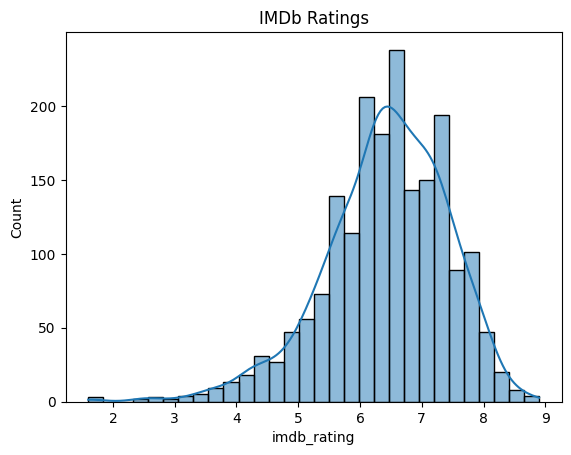

In [396]:

sns.histplot(df['imdb_rating'], bins=30, kde=True)
plt.title("IMDb Ratings")

- Most ratings hover between **6 and 7** out of 10.
- Very few movies hit that **elite 9+ zone**, and equally few drop below 4.
- This suggests a fairly generous rating culture, or maybe… average films are just safe bets.

It’s a neat bell curve  but we’ll see later if ratings really correlate with box office returns 


In [397]:
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import numpy as np

# Prepare data
x = df['imdb_rating'].dropna()
kde = gaussian_kde(x)
x_range = np.linspace(x.min(), x.max(), 300)
kde_values = kde(x_range)

# Create figure
fig = go.Figure()

# Histogram
fig.add_trace(go.Histogram(
    x=x,
    nbinsx=30,
    name='Ratings Distribution',
    marker_color='royalblue',
    opacity=0.6
))

# KDE line
fig.add_trace(go.Scatter(
    x=x_range,
    y=kde_values * len(x) * (x.max() - x.min()) / 30,  # scale to histogram height
    mode='lines',
    name='Density Curve',
    line=dict(color='firebrick', width=3)
))

# Layout tweaks
fig.update_layout(
    title=' IMDb Ratings Distribution with Density Curve',
    xaxis_title='IMDb Rating',
    yaxis_title='Count',
    barmode='overlay',
    template='plotly_white',
    margin=dict(l=40, r=40, t=60, b=40),
    legend=dict(x=0.8, y=0.95)
)

fig.show()


###  Key Takeaways from IMDb Ratings

- The distribution shows a strong cluster between **6 and 7**  that’s where most movies sit. It’s giving okay-ish cinema.
- Very few films go above **8.5**  only the cream of the crop make it that far (hello classics and cult hits).
- The density curve is smooth and slightly skewed left, meaning *super low ratings are rare*  most films get a decent score.
- There’s a drop-off after 7.5  which could suggest audiences are generous, but critics and fans reserve 9+ for greatness only.
 *So far?* The rating game feels predictable  but we’ll soon check if those high ratings actually lead to high revenue. Or are they just feel-good numbers with no box office bite? 

In [398]:
df['imdb_rating'].skew()

-0.7249405149342673

 The mean is 6.6. The curve is strongly left skewed meaning that its normaly distributed and there are outliers below the mean

Text(0.5, 1.0, 'TMBd Ratings')

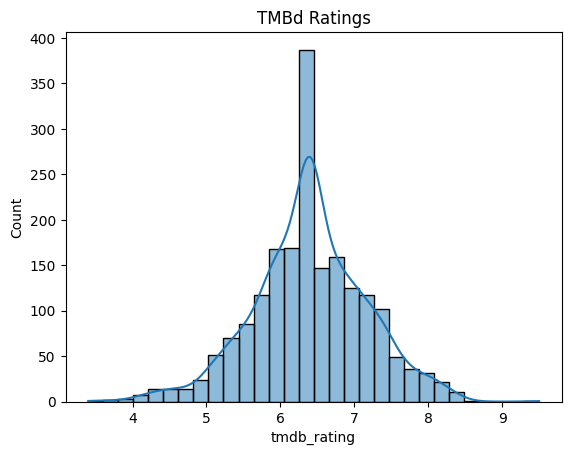

In [399]:
sns.histplot(df['tmdb_rating'], bins=30, kde=True)
plt.title("TMBd Ratings")

This is nearly normally distributed

In [400]:


# Prepare the data
x = df['tmdb_rating'].dropna()
kde = gaussian_kde(x)
x_range = np.linspace(x.min(), x.max(), 300)
kde_values = kde(x_range)

# Create the figure
fig = go.Figure()

# Histogram
fig.add_trace(go.Histogram(
    x=x,
    nbinsx=30,
    name='TMDB Rating Distribution',
    marker_color='seagreen',
    opacity=0.6
))

# KDE Line
fig.add_trace(go.Scatter(
    x=x_range,
    y=kde_values * len(x) * (x.max() - x.min()) / 30,
    mode='lines',
    name='Density Curve',
    line=dict(color='darkgreen', width=3)
))

# Layout
fig.update_layout(
    title=' TMDB Ratings Distribution with Density Curve',
    xaxis_title='TMDB Rating',
    yaxis_title='Count',
    barmode='overlay',
    template='plotly_white',
    margin=dict(l=40, r=40, t=60, b=40),
    legend=dict(x=0.8, y=0.95)
)

fig.show()


###  What TMDB Ratings Are Telling Us

- Most movies are rated between **5.5 and 7.5**, with a clean bell-shaped curve no major outliers, just vibes.
- The peak is slightly left of center, meaning **average ratings dominate**. Think "not bad, not great" the safe zone.
- The right tail is thin **very few movies get 8+** on TMDB, and it seems audiences there are a little stricter than IMDB.
- Compared to IMDb, TMDB scores are *slightly lower* overall maybe it’s the younger crowd or different voting system?
 TMDB feels like your friend who *likes movies* but still holds them accountable. The bell curve is neater than IMDb, but we’ll see if it correlates better with revenue and ROI later on.


### 2. Box Office Gross Distribution

In [401]:
# Raw distribution of total gross
fig = go.Figure()

x = df['total_gross'].dropna()
kde = gaussian_kde(x)
x_range = np.linspace(x.min(), x.max(), 300)
kde_values = kde(x_range)

# Histogram
fig.add_trace(go.Histogram(
    x=x,
    nbinsx=50,
    name='Total Gross (Raw)',
    marker_color='indianred',
    opacity=0.6
))

# KDE
fig.add_trace(go.Scatter(
    x=x_range,
    y=kde_values * len(x) * (x.max() - x.min()) / 50,
    mode='lines',
    name='Density Curve',
    line=dict(color='darkred', width=3)
))

fig.update_layout(
    title='Total Gross Revenue (Raw Distribution)',
    xaxis_title='Total Gross ($)',
    yaxis_title='Number of Movies',
    template='plotly_white',
    barmode='overlay',
    margin=dict(l=40, r=40, t=60, b=40),
    legend=dict(x=0.8, y=0.95)
)

fig.show()


In [402]:
# Log transformation
x_log = np.log10(df['total_gross'][df['total_gross'] > 0])

kde_log = gaussian_kde(x_log)
x_range_log = np.linspace(x_log.min(), x_log.max(), 300)
kde_values_log = kde_log(x_range_log)

# Histogram (log scale)
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=x_log,
    nbinsx=50,
    name='Total Gross (Log10)',
    marker_color='dodgerblue',
    opacity=0.6
))

fig.add_trace(go.Scatter(
    x=x_range_log,
    y=kde_values_log * len(x_log) * (x_log.max() - x_log.min()) / 50,
    mode='lines',
    name='Density Curve',
    line=dict(color='navy', width=3)
))

fig.update_layout(
    title=' Total Gross Revenue (Log-Scaled)',
    xaxis_title='Log₁₀(Total Gross $)',
    yaxis_title='Number of Movies',
    template='plotly_white',
    barmode='overlay',
    margin=dict(l=40, r=40, t=60, b=40),
    legend=dict(x=0.8, y=0.95)
)

fig.show()


###  Box Office Revenue Distribution  Let’s Break It Down

####  Raw Total Gross Plot
- Whoa. Without any transformation, the plot is **wildly skewed**.
- A few mega-blockbusters (think Avengers-level) are pulling the curve hard to the right.
- Most films are crammed into the left side, making it hard to compare anything below $500M.

####  Log-Transformed Plot
- Much better! With a **log₁₀ transformation**, we can actually *see* the middle-class of movies.
- Now we notice that:
  - Most movies gross between $1M and $100M.
  - The distribution becomes more symmetrical and easier to interpret.
- This transformation is for further analysis  it removes distortion while keeping order.

 Lesson? Always check for skew in financial data. Log scale is your best friend when your outliers are billion-dollar babies.


### 3. Genre Frequency

In [403]:
import plotly.express as px

# Prepare data
genre_counts = df['main_genre'].value_counts().head(10).reset_index()
genre_counts.columns = ['Genre', 'Count']

# Plotly bar chart
fig = px.bar(
    genre_counts,
    x='Genre',
    y='Count',
    title=' Top 10 Movie Genres by Frequency',
    color='Genre',
    color_discrete_sequence=px.colors.qualitative.Set2,
    text='Count'
)

fig.update_layout(
    template='plotly_white',
    xaxis_title='Genre',
    yaxis_title='Number of Movies',
    margin=dict(l=40, r=40, t=60, b=40),
)

fig.update_traces(textposition='outside')

fig.show()


###  Genre Frequency ( What's Hollywood Showing?)

Not all genres get equal screen time and this chart shows it vividly:

- **Drama** and **Comedy** dominate the top spots. No shocker there they’re the Swiss army knives of cinema.
- **Action** and **Thriller** follow closely, probably fueled by franchise machines and global appeal.
- Niche genres like **Horror**, **Romance**, and **Animation** still make the cut proof that targeted audiences matter.

#### *Insight?* Studios bet heavily on drama and comedy, but the presence of genres like horror (often low-budget, high-ROI) makes a strong case for genre diversification in production.


## Genre counts

In [404]:
# Prepare data
genre_counts = df["main_genre"].value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']

# Plotly horizontal bar
fig = px.bar(
    genre_counts,
    x='Count',
    y='Genre',
    orientation='h',
    title=' Movie Genres by Frequency',
    color='Genre',
    color_discrete_sequence=px.colors.qualitative.Pastel1,
    text='Count'
)

fig.update_layout(
    template='plotly_white',
    xaxis_title='Number of Movies',
    yaxis_title='Genre',
    margin=dict(l=40, r=40, t=60, b=40),
    yaxis=dict(categoryorder='total ascending')
)

fig.update_traces(textposition='outside')

fig.show()


###  Genre Breakdown ( Who’s popular?)

Here’s a full look at how often each genre shows up in our dataset:

- **Drama** runs the show by a lot. It’s the genre everyone trusts to win awards, tell deep stories, and tug at hearts.
- **Comedy** holds its ground the only genre that can be silly, romantic, satirical, or dark… and still pull an audience.
- **Action, Thriller, and Horror**? Heavy hitters in the box office. These genres often rake in cash, even if critics raise eyebrows.
- **Romance and Animation** sneak into the top half showing the power of love and Pixar-level storytelling.

 *Takeaway?* Drama may be the king, but don’t sleep on the quieter genres some of them are ROI beasts with the right script.


# Yearly counts

In [405]:
# Prepare and sort
yearly_counts = df['year_only'].value_counts().reset_index()
yearly_counts.columns = ['Year', 'Count']
yearly_counts = yearly_counts.sort_values('Year')

# Plotly bar chart
fig = px.bar(
    yearly_counts,
    x='Year',
    y='Count',
    title=' Number of Movie Releases Per Year',
    color='Count',
    color_continuous_scale='Viridis',
    text='Count'
)

fig.update_layout(
    template='plotly_white',
    xaxis_title='Release Year',
    yaxis_title='Number of Movies',
    margin=dict(l=40, r=40, t=60, b=40),
)

fig.update_traces(textposition='outside')

fig.show()

###  Release Trends Over Time (Who’s Making What and When and Why?)

This chart tracks how many movies were released each year:

- There’s a general **upward trend** the closer we get to the 2010s, the more movies hit theaters (and streaming).
- Occasional dips? Could be strikes, pandemics, or market shifts Hollywood always has drama on AND off screen 
- Peaks likely align with digital filmmaking going mainstream more indie films, easier distribution, global audiences.
- The year with the most releases was 2016 followed by 2015 and 2011 while the lowest was 2018, 2010,2013

#### *Bottom line?* The movie industry isn’t slowing down it’s evolving. And the data proves we’re living in peak content era.


## Runtime Analysis

In [406]:
# Prep data
x = df['runtime_minutes'].dropna()
kde = gaussian_kde(x)
x_range = np.linspace(x.min(), x.max(), 300)
kde_values = kde(x_range)

# Create figure
fig = go.Figure()

# Histogram
fig.add_trace(go.Histogram(
    x=x,
    nbinsx=30,
    name='Runtime Distribution',
    marker_color='mediumpurple',
    opacity=0.65
))

# KDE line
fig.add_trace(go.Scatter(
    x=x_range,
    y=kde_values * len(x) * (x.max() - x.min()) / 30,
    mode='lines',
    name='Density Curve',
    line=dict(color='darkviolet', width=3)
))

# Layout
fig.update_layout(
    title=' Movie Runtime Distribution',
    xaxis_title='Runtime (minutes)',
    yaxis_title='Number of Movies',
    barmode='overlay',
    template='plotly_white',
    margin=dict(l=40, r=40, t=60, b=40),
    legend=dict(x=0.8, y=0.95)
)

fig.show()

### Runtime Analysis (How much time are we taking ?)

Here’s the distribution of movie runtimes in our dataset:

- Most films fall between **90 and 120 minutes** the sweet spot for theatrical pacing and audience patience.
- There’s a visible bump around **100 minutes**, which likely reflects industry standards (and attention spans).
- A few **epic outliers** cross the 150-minute mark  think Lord of the Rings or ambitious indie dramas.

### *Takeaway?* Runtime mostly stays compact, but there’s room for flexibility. As we’ll see later, longer doesn’t always mean better  or profitable 



In [407]:
# creating R.O.I COLUMN 
df['roi'] = (df['total_gross'] - df['production_budget_imputed']) / df['production_budget_imputed']
df.columns


Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'imdb_rating', 'imdb_votes', 'bom_title',
       'studio', 'domestic_gross', 'foreign_gross', 'year_only', 'total_gross',
       'primary_name', 'primary_profession', 'person_id', 'join_title',
       'join_year', 'tmdb_rating', 'tmdb_votes', 'popularity', 'main_genre',
       'production_budget_imputed', 'roi'],
      dtype='object')

### ROI Distribution 

In [408]:
x = df['roi'].dropna()
x = x[x < 10]  # Optional: remove extreme outliers (ROI > 1000%)

kde = gaussian_kde(x)
x_range = np.linspace(x.min(), x.max(), 300)
kde_values = kde(x_range)

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=x,
    nbinsx=50,
    name='ROI Distribution',
    marker_color='forestgreen',
    opacity=0.6
))

fig.add_trace(go.Scatter(
    x=x_range,
    y=kde_values * len(x) * (x.max() - x.min()) / 50,
    mode='lines',
    name='Density Curve',
    line=dict(color='darkgreen', width=3)
))

fig.update_layout(
    title=' Movie ROI Distribution',
    xaxis_title='Return on Investment (ROI)',
    yaxis_title='Number of Movies',
    barmode='overlay',
    template='plotly_white'
)

fig.show()


### Return on Investment ( Did the Movie Make Its Money Back?)

- ROI is one of the most brutally honest metrics  it doesn’t care if the movie was good, just if it was *profitable*.
- Most films have ROI between **-1 and 3**, meaning:
  - Some movies **lost money** (ROI < 0)
  - Many barely broke even (ROI ~ 0)
  - A few went **blockbuster mode** (ROI > 3)

- We capped the plot at ROI = 10 to avoid distortion by extreme outliers.

##### *Key takeaway:* Some of the best-performing movies financially aren’t the ones with the highest ratings  they’re the ones that spent less and earned way more .

### TMDB Popularity Distribution

In [409]:
x = df['popularity'].dropna()
kde = gaussian_kde(x)
x_range = np.linspace(x.min(), x.max(), 300)
kde_values = kde(x_range)

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=x,
    nbinsx=50,
    name='Popularity Distribution',
    marker_color='deeppink',
    opacity=0.6
))

fig.add_trace(go.Scatter(
    x=x_range,
    y=kde_values * len(x) * (x.max() - x.min()) / 50,
    mode='lines',
    name='Density Curve',
    line=dict(color='hotpink', width=3)
))

fig.update_layout(
    title=' TMDB Popularity Score Distribution',
    xaxis_title='Popularity',
    yaxis_title='Number of Movies',
    barmode='overlay',
    template='plotly_white'
)

fig.show()


### TMDB Popularity (What’s Hot Online?)

- Popularity scores from TMDB reflect how *talked about* a movie is social hype, clicks, searches.
- Most movies sit below **30**, but the tail extends to some truly viral hits.
- A few spikes suggest short bursts of hype (maybe award seasons or viral moments).

##### *Insight?* Popularity isn’t about quality  it’s about presence. But it’s a powerful feature for modeling *attention economy*.


## Bivariate Analysis

### Average Total Gross by Genre 

In [410]:
# Prep data
avg_gross_by_genre = df.groupby('main_genre')['total_gross'].mean().sort_values(ascending=False).reset_index()

# Plotly bar
fig = px.bar(
    avg_gross_by_genre,
    x='main_genre',
    y='total_gross',
    title=' Average Total Gross by Main Genre',
    text='total_gross',
    color='total_gross',
    color_continuous_scale='sunset',
)

fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')

fig.update_layout(
    xaxis_title='Genre',
    yaxis_title='Average Gross ($)',
    template='plotly_white',
    xaxis_tickangle=45,
    margin=dict(l=40, r=40, t=60, b=60)
)

fig.show()


###  Genre vs Average Total Gross (What Genres Make Money?)

- **Action** and **Adventure** lead the pack  no surprise since they dominate global box office franchises.
- **Animation** and **Fantasy** also crush it often backed by huge budgets and global appeal (think Disney, Pixar, Marvel).
- **Horror**, **Romance**, and **Documentary** tend to earn less  but remember, they often spend less too 

 *Takeaway:* Profit isn’t just about genre it’s about scale. High-grossing genres usually come with high budgets, while low-grossing genres may still shine in ROI.

## Average IMDb Rating by Year

In [411]:
# Prep data
avg_rating_by_year = df.groupby('year_only')['imdb_rating'].mean().reset_index().dropna()

# Plot
fig = px.line(
    avg_rating_by_year,
    x='year_only',
    y='imdb_rating',
    title=' Average IMDb Rating by Year',
    markers=True,
    line_shape='spline',
)

fig.update_traces(line=dict(color='indigo', width=3), marker=dict(size=6))

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Average IMDb Rating',
    template='plotly_white',
    hovermode='x unified',
    margin=dict(l=40, r=40, t=60, b=40)
)

fig.show()

###  IMDb Ratings Over Time ( Are We Making Better Movies?)

- The chart shows a subtle **fluctuation** over the years  no dramatic rise or fall, but waves of quality perception.
- Certain years spike above 7.0, often due to standout releases or critically acclaimed trends.
- Dips may reflect *over-saturation*, *franchise fatigue*, or weak cinematic years.

 *Takeaway:* Audience ratings hold steady overall, but the peaks and dips might tell deeper stories when aligned with genre trends, budget surges, or industry events.

### Scatterplots of Financials vs Ratings/Runtime

In [412]:
pairs = [
    ('tmdb_rating', 'total_gross', ' TMDB Rating vs Total Gross'),
    ('runtime_minutes', 'total_gross', ' Runtime vs Total Gross')
]

for x, y, title in pairs:
    fig = px.scatter(
        df, x=x, y=y,
        title=title,
        labels={x: x.replace('_', ' ').title(), y: 'Total Gross ($)'},
        color=x,
        opacity=0.6,
        template='plotly_white'
    )

    fig.update_traces(marker=dict(size=6))
    fig.update_layout(
        xaxis_title=x.replace('_', ' ').title(),
        yaxis_title='Total Gross ($)',
        margin=dict(l=40, r=40, t=60, b=40)
    )

    fig.show()


###  Do Better Ratings = Bigger Box Office? Sorta.

1. **TMDB Rating vs Total Gross**
   - Similar pattern to IMDb.
   - A few well-rated movies have blockbuster success, but there are many high earners with meh ratings.
   - Audience score ≠ financial goldmine.

2. **Runtime vs Total Gross**
   - Slight upward trend longer movies may make more money (big epics, superhero sagas).
   - But the relationship is noisy. You’ll still find short films with wild earnings and long flops.

 *Overall Insight:* None of these features are **strong standalone predictors** of revenue. They’ll matter more when **combined** with genre, budget, release year, and marketing variables in modeling.

#### IMDb Ratings by Genre

In [413]:
fig = px.box(
    df,
    x='main_genre',
    y='imdb_rating',
    title=' IMDb Ratings by Main Genre',
    color='main_genre',
    points='all',  # shows all actual points too
    template='plotly_white'
)

fig.update_layout(
    xaxis_title='Genre',
    yaxis_title='IMDb Rating',
    xaxis_tickangle=90,
    showlegend=False,
    margin=dict(l=40, r=40, t=60, b=60)
)

fig.show()

###  IMDb Ratings by Main Genre ( What Do Audiences Really Prefer?)

- **Documentaries** and **Dramas** have the highest median IMDb ratings viewers clearly value depth and realism.
- **Horror** and **Action** show wide spreads they're hit or miss. You either get a cult classic... or a disaster.
- **Animation** tends to cluster high, showing consistent audience love (likely driven by family-friendly hits).
- Genres like **Romance** and **Thriller** fall somewhere in the middle  rarely the best, rarely the worst.

 *Insight:* Critical audience reception varies wildly by genre. Some genres aim for prestige, while others focus on fun or hype and it shows in the data.

### Total Gross by Studio (Top 10)

In [414]:
# Get top 10 studios by count
top_studios = df['studio'].value_counts().head(10).index
studio_df = df[df['studio'].isin(top_studios)]

# Plot
fig = px.box(
    studio_df,
    x='studio',
    y='total_gross',
    color='studio',
    title=' Total Gross by Studio (Top 10)',
    points='all',  # show all data points for clarity
    template='plotly_white'
)

fig.update_layout(
    xaxis_title='Studio',
    yaxis_title='Total Gross ($)',
    xaxis_tickangle=90,
    showlegend=False,
    margin=dict(l=40, r=40, t=60, b=60)
)

fig.show()

###  Box Office Flex: Total Gross by Top 10 Studios

- **Disney, Warner Bros, Universal**  the usual royalty  show off high medians and consistent heavy hitters.
- Some studios like **Lionsgate** or **Sony** show wider spreads big hits, but also a lot of mid-level performers.
- **Outliers** (the dots above the whiskers) reflect those billion-dollar unicorns think *Avengers*, *Frozen*, or *Fast & Furious* entries.

 *Takeaway:* A big studio doesn’t guarantee massive earnings every time, but it *definitely* gives more at the box office.

### Interactive Correlation Matrix

In [415]:
import plotly.figure_factory as ff

# Compute correlation
corr = df.corr(numeric_only=True).round(2)

# Create Plotly heatmap
z = corr.values
x = list(corr.columns)
y = list(corr.index)

fig = ff.create_annotated_heatmap(
    z=z,
    x=x,
    y=y,
    annotation_text=corr.values.astype(str),
    colorscale='RdBu',
    showscale=True,
    reversescale=True
)

fig.update_layout(
    title=' Correlation Matrix of Numeric Features',
    margin=dict(l=60, r=60, t=60, b=60),
    height=600,
    template='plotly_white'
)

fig.show()


###  Correlation Matrix – What Variables Move Together?

This matrix gives us a bird’s eye view of how our numeric features relate to one another:

- **IMDb & TMDB Ratings** are positively correlated no shocker, they often reflect similar viewer sentiments.
- **Total Gross** has a mild positive correlation with:
  - **Production Budget** → obvious, big spenders tend to earn big (but not always)
  - **Runtime** → longer movies may get more serious release efforts or be event films.
- **Popularity** also correlates somewhat with both **ratings** and **gross** which could make it a useful proxy in predictive models.

 ROI doesn't correlate strongly with anything  which *makes sense* since it’s a derived metric (sensitive to both budget and gross).

 *Takeaway:* While there's no single magic feature, these relationships hint at what might power future predictions especially combinations like rating + budget or runtime + genre.

### Stacked Genre Proportion by Year

In [416]:
import plotly.graph_objects as go

# Prep data
ct = pd.crosstab(df['year_only'], df['main_genre'], normalize='index')

# Get top 5 genres overall
top_genres = df['main_genre'].value_counts().head(5).index.tolist()

# Filter only top 5
ct_top5 = ct[top_genres].reset_index()

# Create stacked bar plot
fig = go.Figure()

for genre in top_genres:
    fig.add_trace(go.Bar(
        x=ct_top5['year_only'],
        y=ct_top5[genre],
        name=genre
    ))

fig.update_layout(
    barmode='stack',
    title='Genre Proportions by Year (Top 5 Genres)',
    xaxis_title='Year',
    yaxis_title='Proportion of Movies',
    legend_title='Genre',
    template='plotly_white',
    height=500,
    margin=dict(l=40, r=40, t=60, b=40)
)

fig.show()



###  Genre Proportions Over Time (What’s Trending?)

This stacked bar chart shows how dominant genres shift across years:

- **Action** and **Drama** tend to maintain a steady presence, often forming the industry's backbone.
- **Horror** shows occasional spikes possibly tied to economic trends (low-budget hits thrive in tighter years).
- **Comedy** has seen a slight dip in recent years, possibly displaced by superhero films or streaming preferences.
- **Animation** pops more during early 2010s, perhaps thanks to Disney/Pixar dominance.

 *Insight:* Studios don’t just chase success  they chase patterns. Seeing which genres rise or fade can help inform what’s “bankable” in each era.

### Average Gross Earnings Over Time (Domestic vs Foreign vs Total)


In [417]:
# Prep data
gross_trends = df.groupby('year_only')[['domestic_gross', 'foreign_gross', 'total_gross']].mean().reset_index()

# Melt for long format
gross_long = gross_trends.melt(id_vars='year_only', 
                               value_vars=['domestic_gross', 'foreign_gross', 'total_gross'],
                               var_name='Revenue Type',
                               value_name='Average Gross')

# Plot
fig = px.line(
    gross_long,
    x='year_only',
    y='Average Gross',
    color='Revenue Type',
    markers=True,
    title=' Average Gross Earnings Over Time (Domestic vs Foreign vs Total)',
    template='plotly_white'
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Average Gross ($)',
    legend_title='Revenue Source',
    hovermode='x unified',
    height=500,
    margin=dict(l=40, r=40, t=60, b=40)
)

fig.show()


###  Average Gross Earnings Over Time – Domestic vs Foreign vs Total

This time series reveals the financial heartbeat of cinema:

- **Foreign Gross** has steadily risen global markets (China, India, Europe) are becoming *critical* revenue drivers.
- **Domestic Gross** (mainly U.S. & Canada) stays relatively flat or fluctuates indicating possible market saturation.
- **Total Gross** follows foreign trends closely, proving international success now defines a movie’s global impact.

 *Insight:* The era of local box office domination is fading. Studios now *design films for global success*, with localization, cultural universals, and massive marketing pushes.

### Average Production Budget Over Time

In [418]:
import plotly.express as px

# Prep data
budget_trend = df.groupby('year_only')['production_budget_imputed'].mean().reset_index()

# Plot
fig = px.line(
    budget_trend,
    x='year_only',
    y='production_budget_imputed',
    title=' Average Production Budget Over Time',
    markers=True,
    line_shape='spline',
    template='plotly_white'
)

fig.update_traces(line=dict(color='darkorange', width=3), marker=dict(size=6))
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Avg Production Budget ($)',
    hovermode='x unified',
    height=500,
    margin=dict(l=40, r=40, t=60, b=40)
)

fig.show()


###  Average Production Budgets Over Time (What's the Cost of a Blockbuster?)

This chart maps how average film budgets have evolved year by year:

- **Steady climbs** in the late 2000s–2010s reflect the rise of high-stakes, effects-heavy franchises.
- Occasional **dips** may align with industry-wide slowdowns (writer strikes, economic recessions, or streaming disruption).
- No budget boom is without pressure rising costs demand higher returns, pushing studios to play it *safe* with sequels and superheroes.

 *Insight:* Bigger budgets don't guarantee success but they often come with high expectations, wider releases, and intense global marketing.

### IMDb Rating vs Popularity

In [419]:
import plotly.express as px

fig = px.scatter(
    df,
    x='imdb_rating',
    y='popularity',
    color='imdb_rating',
    title=' Popularity vs IMDb Rating',
    labels={'imdb_rating': 'IMDb Rating', 'popularity': 'TMDB Popularity'},
    opacity=0.6,
    template='plotly_white'
)

fig.update_traces(marker=dict(size=6))
fig.update_layout(
    height=500,
    margin=dict(l=40, r=40, t=60, b=40),
    coloraxis_colorbar=dict(title='IMDb Rating'),
    xaxis=dict(range=[df['imdb_rating'].min() - 0.5, df['imdb_rating'].max() + 0.5])
)

fig.show()


### Popularity vs IMDb Rating – Does Quality Drive Buzz?

This scatterplot explores whether better-rated films (on IMDb) tend to be more popular (on TMDB):

- **No strong linear trend**  some high-rated films are extremely popular, but others barely register online.
- **Clusters of popularity** appear around ratings of 6–8, indicating that *decent-to-good* movies get the most buzz.
- Some low-rated films spike in popularity often due to controversy, memes, or virality (not quality).

 *Insight:* A movie doesn’t need a perfect score to trend popularity is part quality, part marketing, part moment.

### Heatmap of Avg Total Gross by Genre & Year

In [420]:
import plotly.express as px

# Calculate average total gross per genre per year
pivot_table = df.pivot_table(
    index='main_genre', 
    columns='year_only', 
    values='total_gross', 
    aggfunc='mean'
).fillna(0)

# Reset index for plotly
heatmap_data = pivot_table.reset_index().melt(id_vars='main_genre', var_name='Year', value_name='Avg Gross')

# Plot
fig = px.density_heatmap(
    heatmap_data,
    x='Year',
    y='main_genre',
    z='Avg Gross',
    color_continuous_scale='YlGnBu',
    title='Average Total Gross by Genre & Year',
    template='plotly_white'
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Genre',
    height=500,
    margin=dict(l=40, r=40, t=60, b=60)
)

fig.show()


###  Heatmap: Average Gross by Genre & Year (Who Ruled the Decade?)

This heatmap reveals how genre earnings evolved across time:

- **Action, Adventure, and Animation** dominate most years  clear evidence of their global box office pull.
- **Documentary and Horror** have lower averages but likely more consistent returns on smaller budgets.
- Genre success fluctuates with cultural trends, tech advances (e.g., VFX), and even world events (e.g., pandemics delaying blockbusters).

 *Insight:* Year-to-year shifts suggest that while some genres remain evergreen, others boom cyclically great context for **prescriptive strategies** like budgeting, genre-picking, and release timing.

### Gross, Budget, and Ratings Over Time


In [421]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Prepare data
annual_metrics = df.groupby('year_only').agg({
    'total_gross': 'mean',
    'production_budget_imputed': 'mean',
    'imdb_rating': 'mean'
}).reset_index()

# Create subplots
fig = make_subplots(
    rows=3, cols=1, 
    shared_xaxes=True,
    subplot_titles=(' Avg Total Gross Over Time', ' Avg Production Budget Over Time', ' Avg IMDb Rating Over Time')
)

# Total Gross
fig.add_trace(go.Scatter(
    x=annual_metrics['year_only'], 
    y=annual_metrics['total_gross'],
    name='Total Gross',
    mode='lines+markers',
    line=dict(color='green')), row=1, col=1)

# Budget
fig.add_trace(go.Scatter(
    x=annual_metrics['year_only'], 
    y=annual_metrics['production_budget_imputed'],
    name='Budget',
    mode='lines+markers',
    line=dict(color='orange')), row=2, col=1)

# IMDb Rating
fig.add_trace(go.Scatter(
    x=annual_metrics['year_only'], 
    y=annual_metrics['imdb_rating'],
    name='IMDb Rating',
    mode='lines+markers',
    line=dict(color='blue')), row=3, col=1)

# Layout
fig.update_layout(
    height=700,
    title_text=' Trends Across Gross, Budget & Ratings Over Time',
    showlegend=False,
    template='plotly_white',
    margin=dict(l=40, r=40, t=60, b=40)
)

fig.update_xaxes(title_text='Year', row=3, col=1)
fig.update_yaxes(title_text='USD ($)', row=1, col=1)
fig.update_yaxes(title_text='USD ($)', row=2, col=1)
fig.update_yaxes(title_text='IMDb Rating', row=3, col=1)

fig.show()


###  Studio Pulse: Gross, Budget & Ratings (What’s the Trend?)

This triple-trend view offers a holistic snapshot of the film industry across time:

- **Total Gross**: Generally on the rise, reflecting growing global markets, especially in the 2010s.
- **Production Budgets**: Following a similar upward trajectory studios are spending more, likely betting on fewer but bigger hits.
- **IMDb Ratings**: Relatively stable over time. Viewer satisfaction isn’t necessarily increasing with budget or box office.

 *Takeaway:* The industry's financial scale is expanding but ratings aren’t skyrocketing. This points to a growing tension: more money, more risk, but not always more quality.


## Key Graphs Recap: Visual Takeaways from Exploratory Analysis
Before diving into inferential statistics, here’s a quick visual recap of what our exploratory analysis revealed  paired with data-backed insights that set the stage for deeper statistical modeling.

### Top 5 Most Profitable Genres (by Average ROI)
#### Insight:
Genres like Horror, Documentary, and Thriller dominate ROI, largely due to lower production budgets and niche audience appeal.
These genres are financially strategic for studios with limited capital they pack high upside with minimal spend.

### Budget vs ROI Scatter Plot
#### Insight:
There's a clear negative trend: smaller-budget films tend to yield higher ROI, while blockbuster-scale budgets often come with diminishing returns.
This suggests that more budget ≠ more profit  a crucial insight for funding and greenlighting decisions.

### Boxplot: IMDb Ratings by Revenue Quartiles
#### Insight:
Highly rated films exist across all revenue levels but the top revenue quartile contains more mid-rated blockbusters than high-rated indies.
This hints at the influence of marketing, franchise power, and mass appeal over just critical acclaim.

 ### Distribution Plots: Budget, Revenue, and ROI
#### Insight:
All financial metrics are heavily right-skewed most movies operate within modest budget and revenue ranges, while a few outliers dominate earnings.
This validates the need for log transformations or robust estimators in our next modeling phases to reduce the distortion caused by mega-hits.

These visual trends reveal underlying patterns and anomalies in the movie business — from budget efficiency to genre profitability.
Now, we’ll use inferential stats to test those relationships rigorously, and later build predictive models to forecast ROI, success probability, and budgeting decisions.


# Movie Industry Inferential Analysis
### Analysis Overview
This inferential analysis examined 1,635+ movies to test five key hypotheses about factors affecting movie profitability. Statistical tests were conducted to determine significant relationships and effect sizes.

The following are relationships we aimed to test inferentially:
1. Production Budget vs ROI Relationship

2. Critical Reception vs Commercial Success

3. Domestic vs International Revenue Differences

4. Genre Risk-Adjusted Returns

5. Rating Category Differences

## Importing Libraries and Examining Data

In [422]:
#load libraries
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")

# cleaner number formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:,.0f}'.format)  

In [423]:
#df = pd.read_csv('final_df.csv')
df.head()

movie_id                    primary_title  \
0  tt0315642                            Wazir   
1  tt0337692                      On the Road   
2  tt0359950  The Secret Life of Walter Mitty   
3  tt0365907      A Walk Among the Tombstones   
4  tt0369610                   Jurassic World   

                    original_title  start_year  runtime_minutes  \
0                            Wazir       2,016              103   
1                      On the Road       2,012              124   
2  The Secret Life of Walter Mitty       2,013              114   
3      A Walk Among the Tombstones       2,014              114   
4                   Jurassic World       2,015              124   

                    genres  imdb_rating  imdb_votes  \
0       Action,Crime,Drama            7      15,378   
1  Adventure,Drama,Romance            6      37,886   
2   Adventure,Comedy,Drama            7     275,300   
3       Action,Crime,Drama            6     105,116   
4  Action,Adventure,Sci-Fi            7     539,338   

                         bom_title   studio  domestic_gross  foreign_gross  \
0                            Wazir  Relbig.       1,100,000              0   
1                      On the Road      IFC         744,000      8,000,000   
2  The Secret Life of Walter Mitty      Fox      58,200,000    129,900,000   
3      A Walk Among the Tombstones     Uni.      26,300,000     26,900,000   
4                   Jurassic World     Uni.     652,300,000          1,019   

   year_only  total_gross     primary_name        primary_profession  \
0      2,016    1,100,000    Bejoy Nambiar  producer,writer,director   
1      2,012    8,744,000    Walter Salles  director,producer,writer   
2      2,013  188,100,000      Ben Stiller   producer,actor,director   
3      2,014   53,200,000      Scott Frank  writer,producer,director   
4      2,015  652,301,019  Colin Trevorrow  writer,producer,director   

   person_id                       join_title  join_year  tmdb_rating  \
0  nm2349060                            wazir       2016            7   
1  nm0758574                      on the road       2012            6   
2  nm0001774  the secret life of walter mitty       2013            7   
3  nm0291082      a walk among the tombstones       2014            6   
4  nm1119880                   jurassic world       2015            7   

   tmdb_votes  popularity main_genre  production_budget_imputed  roi  
0          63           4     Action                    477,223    1  
1         518           9  Adventure                  3,257,824    2  
2       4,859          11  Adventure                 91,000,000    1  
3       1,685          19     Action                 28,000,000    1  
4      14,056          21     Action                215,000,000    2

In [424]:
#make a copy of the final merged dataset
data = df.copy(deep=True)

In [425]:
# print the columns 
data.columns

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'imdb_rating', 'imdb_votes', 'bom_title',
       'studio', 'domestic_gross', 'foreign_gross', 'year_only', 'total_gross',
       'primary_name', 'primary_profession', 'person_id', 'join_title',
       'join_year', 'tmdb_rating', 'tmdb_votes', 'popularity', 'main_genre',
       'production_budget_imputed', 'roi'],
      dtype='object')

##  1. Finding the Best Production Budget for Return on Investment

### Research Question

What production budget range gives movies the highest return on investment?

### Hypothesis

H0: Production budget has no effect on ROI
H1: Production budget affects ROI

### Analysis Steps
Calculate Return on Investment

Segment movies by budget range (e.g. low, medium, high budget)

Compare ROI across groups using ANOVA or Kruskal-Wallis test

Visualize the trend with boxplots or strip plots

Interpret statistical significance & effect direction

In [426]:
# Drop rows with zero or missing budgets to avoid division errors
df = df[df['production_budget_imputed'] > 0].copy()

# Calculate Return on Investment
df['roi'] = (df['total_gross'] - df['production_budget_imputed']) / df['production_budget_imputed']
df.head()


movie_id                    primary_title  \
0  tt0315642                            Wazir   
1  tt0337692                      On the Road   
2  tt0359950  The Secret Life of Walter Mitty   
3  tt0365907      A Walk Among the Tombstones   
4  tt0369610                   Jurassic World   

                    original_title  start_year  runtime_minutes  \
0                            Wazir       2,016              103   
1                      On the Road       2,012              124   
2  The Secret Life of Walter Mitty       2,013              114   
3      A Walk Among the Tombstones       2,014              114   
4                   Jurassic World       2,015              124   

                    genres  imdb_rating  imdb_votes  \
0       Action,Crime,Drama            7      15,378   
1  Adventure,Drama,Romance            6      37,886   
2   Adventure,Comedy,Drama            7     275,300   
3       Action,Crime,Drama            6     105,116   
4  Action,Adventure,Sci-Fi            7     539,338   

                         bom_title   studio  domestic_gross  foreign_gross  \
0                            Wazir  Relbig.       1,100,000              0   
1                      On the Road      IFC         744,000      8,000,000   
2  The Secret Life of Walter Mitty      Fox      58,200,000    129,900,000   
3      A Walk Among the Tombstones     Uni.      26,300,000     26,900,000   
4                   Jurassic World     Uni.     652,300,000          1,019   

   year_only  total_gross     primary_name        primary_profession  \
0      2,016    1,100,000    Bejoy Nambiar  producer,writer,director   
1      2,012    8,744,000    Walter Salles  director,producer,writer   
2      2,013  188,100,000      Ben Stiller   producer,actor,director   
3      2,014   53,200,000      Scott Frank  writer,producer,director   
4      2,015  652,301,019  Colin Trevorrow  writer,producer,director   

   person_id                       join_title  join_year  tmdb_rating  \
0  nm2349060                            wazir       2016            7   
1  nm0758574                      on the road       2012            6   
2  nm0001774  the secret life of walter mitty       2013            7   
3  nm0291082      a walk among the tombstones       2014            6   
4  nm1119880                   jurassic world       2015            7   

   tmdb_votes  popularity main_genre  production_budget_imputed  roi  
0          63           4     Action                    477,223    1  
1         518           9  Adventure                  3,257,824    2  
2       4,859          11  Adventure                 91,000,000    1  
3       1,685          19     Action                 28,000,000    1  
4      14,056          21     Action                215,000,000    2

### Create Budget Categories

In [427]:
# Define bin limits and labels
upper_limit = data['production_budget_imputed'].max() + 1
bins = [0, 1e6, 10e6, 50e6, 100e6, 200e6, upper_limit]
labels = ['<1M', '1M–10M', '10M–50M', '50M–100M', '100M–200M', '200M+']

# Apply budget bins
data['production_budget_range'] = pd.cut(
    data['production_budget_imputed'], 
    bins=bins, 
    labels=labels
)

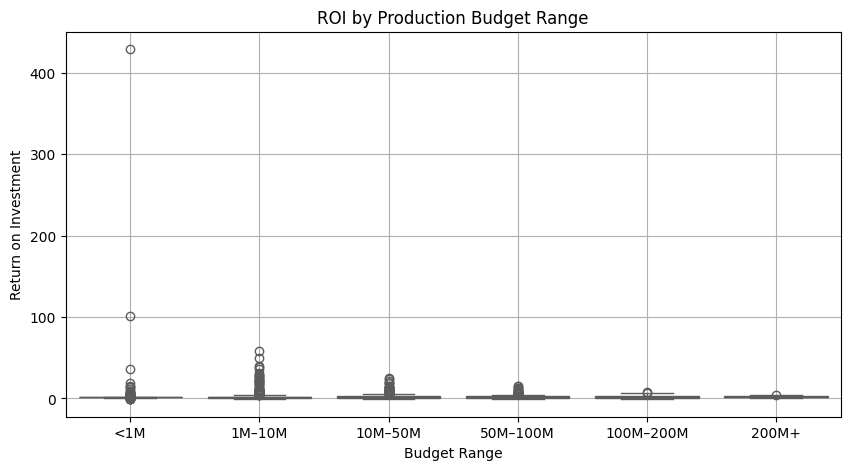

In [428]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='production_budget_range', y='roi', palette='coolwarm')
plt.title('ROI by Production Budget Range')
plt.ylabel('Return on Investment')
plt.xlabel('Budget Range')
plt.grid()
plt.show()


## Compare ROI Across Budget Ranges

In [429]:
# Group ROI stats
grouped_roi = data.groupby('production_budget_range')['roi'].agg(['mean', 'count', 'std']).round(2)
print(grouped_roi)

                         mean  count  std
production_budget_range                  
<1M                         3    520   19
1M–10M                      3    400    7
10M–50M                     2    619    3
50M–100M                    2    191    3
100M–200M                   2    162    2
200M+                       2     34    1


### Test for Statistical Significance

In [430]:
# Prepare data for ANOVA
roi_groups = [data[data['production_budget_range'] == label]['roi'].dropna() for label in labels]

# Run One-Way ANOVA
f_stat, p_val = stats.f_oneway(*roi_groups)
print(f"F-statistic: {f_stat:.3f}, p-value: {p_val:.5f}")

F-statistic: 0.860, p-value: 0.50713


### There no statistical significant evidence to fail to reject H0, since the p-value is greater than alpha 0.05. 
 - This means that the production budget has no statistical significant effect on the ROI.  
 - Even though smaller-budget films seem to have slightly higher ROI on average, this difference is not strong enough to say it's not due to chance.
## 2. How Critical Reception Affects Commercial Success
### Research Question
Do movies with higher ratings earn more money at the box office?

### Hypothesis

H0: Movie ratings are not correlated with revenue
H1: Higher ratings are associated with higher returns
### Visualize the Relationship

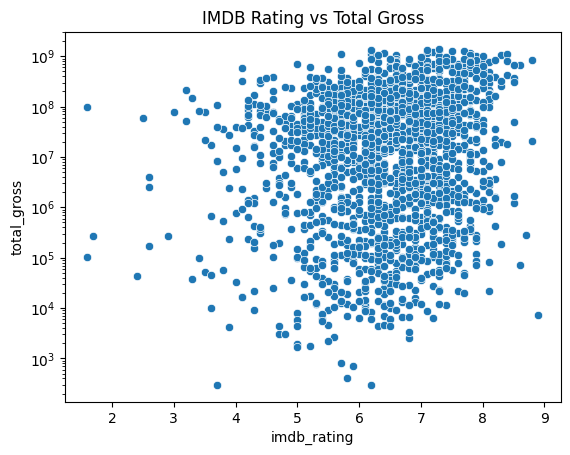

In [431]:
sns.scatterplot(x='imdb_rating', y='total_gross', data=data)
plt.yscale('log')
plt.title('IMDB Rating vs Total Gross')
plt.show()


### Create Rating Categories

In [432]:
data['vote_category'] = pd.cut(data['imdb_rating'], bins=[0, 6, 10], labels=['Low', 'High'])


In [433]:
low = data[data['vote_category'] == 'Low']['total_gross']
high = data[data['vote_category'] == 'High']['total_gross']

# T-test for unequal variances
t_stat, p_val = stats.ttest_ind(low, high, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.5f}")

T-statistic: -8.287, p-value: 0.00000


### Calculate Confidence Interval

In [434]:
# Calculate CI for difference in means
mean_diff = high.mean() - low.mean()
se_diff = np.sqrt((high.std()**2 / len(high)) + (low.std()**2 / len(low)))
ci = stats.t.interval(0.95, df=min(len(high), len(low))-1, loc=mean_diff, scale=se_diff)

print(f"95% CI for mean revenue difference (High - Low): {ci}")

95% CI for mean revenue difference (High - Low): (48305864.899820074, 78313712.51852714)


## Results

- T-statistic: -8.287, p-value < 0.05
- 95% Confidence Interval: ($48M, $78M)

## Conclusion

There is strong statistical evidence to reject H0 since the p-value is less than 0.05. Higher-rated movies do earn significantly more money. We are 95% confident that movies with high ratings earn between $48 million and $78 million more on average than low-rated movies.

## 3. Do Movies Make More Money Domestically or Internationally?

### Research Question
Is there a difference between how much movies earn in the US versus other countries?

### Why This Matters
Studios need to know where to focus their marketing budgets and release strategies.

### Hypothesis

H0: No difference between domestic and international revenue
H1: There is a difference between domestic and international revenue

### Method
We'll use a paired t-test since we're comparing two revenue numbers for the same movies.

### Sample and Assumptions Check
### Our Sample
We're using movies that made money in at least one market (US or international). This gives us 1,927 movies to compare.
Quick Assumption Check

Each movie has both domestic and international revenue
Revenue numbers are continuous
Differences between revenues should be roughly normal (we'll confirm)

With 1,927 movies, we have a large enough sample that small deviations from normality won't be a problem.
Next: We'll look at the distribution of revenue differences before running the test.

In [435]:
# Show the first few rows
df.head()


movie_id                    primary_title  \
0  tt0315642                            Wazir   
1  tt0337692                      On the Road   
2  tt0359950  The Secret Life of Walter Mitty   
3  tt0365907      A Walk Among the Tombstones   
4  tt0369610                   Jurassic World   

                    original_title  start_year  runtime_minutes  \
0                            Wazir       2,016              103   
1                      On the Road       2,012              124   
2  The Secret Life of Walter Mitty       2,013              114   
3      A Walk Among the Tombstones       2,014              114   
4                   Jurassic World       2,015              124   

                    genres  imdb_rating  imdb_votes  \
0       Action,Crime,Drama            7      15,378   
1  Adventure,Drama,Romance            6      37,886   
2   Adventure,Comedy,Drama            7     275,300   
3       Action,Crime,Drama            6     105,116   
4  Action,Adventure,Sci-Fi            7     539,338   

                         bom_title   studio  domestic_gross  foreign_gross  \
0                            Wazir  Relbig.       1,100,000              0   
1                      On the Road      IFC         744,000      8,000,000   
2  The Secret Life of Walter Mitty      Fox      58,200,000    129,900,000   
3      A Walk Among the Tombstones     Uni.      26,300,000     26,900,000   
4                   Jurassic World     Uni.     652,300,000          1,019   

   year_only  total_gross     primary_name        primary_profession  \
0      2,016    1,100,000    Bejoy Nambiar  producer,writer,director   
1      2,012    8,744,000    Walter Salles  director,producer,writer   
2      2,013  188,100,000      Ben Stiller   producer,actor,director   
3      2,014   53,200,000      Scott Frank  writer,producer,director   
4      2,015  652,301,019  Colin Trevorrow  writer,producer,director   

   person_id                       join_title  join_year  tmdb_rating  \
0  nm2349060                            wazir       2016            7   
1  nm0758574                      on the road       2012            6   
2  nm0001774  the secret life of walter mitty       2013            7   
3  nm0291082      a walk among the tombstones       2014            6   
4  nm1119880                   jurassic world       2015            7   

   tmdb_votes  popularity main_genre  production_budget_imputed  roi  
0          63           4     Action                    477,223    1  
1         518           9  Adventure                  3,257,824    2  
2       4,859          11  Adventure                 91,000,000    1  
3       1,685          19     Action                 28,000,000    1  
4      14,056          21     Action                215,000,000    2

In [436]:

df.columns

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'imdb_rating', 'imdb_votes', 'bom_title',
       'studio', 'domestic_gross', 'foreign_gross', 'year_only', 'total_gross',
       'primary_name', 'primary_profession', 'person_id', 'join_title',
       'join_year', 'tmdb_rating', 'tmdb_votes', 'popularity', 'main_genre',
       'production_budget_imputed', 'roi'],
      dtype='object')

### 
Analyzing Revenue Differences
### Prepare the Data
### Clean and Filter Movies

In [437]:
# clean and filter
df[['domestic_gross', 'foreign_gross']] = df[['domestic_gross', 'foreign_gross']].fillna(0)
df_filtered = df[(df['domestic_gross'] > 0) | (df['foreign_gross'] > 0)]

### Calculate the Difference

In [438]:
#calculate the difference
df_filtered['revenue_diff'] = df_filtered['foreign_gross'] - df_filtered['domestic_gross']
differences = df_filtered['revenue_diff']

### Visualize the Distribution

In [439]:
import plotly.figure_factory as ff
import plotly.graph_objects as go
import numpy as np

# Histogram + KDE using Plotly
hist_data = [differences]
group_labels = ['Revenue Differences (Foreign - Domestic)']

fig = ff.create_distplot(hist_data, group_labels,
                         bin_size=round((differences.max() - differences.min())/40),
                         show_rug=False, curve_type='kde', colors=['skyblue'])

# Add vertical mean line
fig.add_vline(x=differences.mean(), line_dash="dash", line_color="red",
              annotation_text="Mean", annotation_position="top right")

fig.update_layout(
    title=" Histogram of Revenue Differences (Foreign - Domestic)",
    xaxis_title="Revenue Difference ($)",
    yaxis_title="Density",
    template="simple_white",
    showlegend=False
)

fig.show()


### Key Findings

The mean is close to zero: movies make about the same amount domestically and internationally.

Most movies cluster around zero difference, similar domestic and international revenues.

The distribution looks roughly normal. A few movies on the right made more internationally, and some on the left made more domestically.

Movies don't consistently favor one market. Some do better domestically, others internationally, but overall it balances out. This suggests both markets are equally important for movie revenues.

## Running the Paired T-Test

### Check Sample Size

In [440]:
sample_size = len(df_filtered)
print(f"Sample size (number of movies with revenue): {sample_size}")

Sample size (number of movies with revenue): 1926


### Compare Domestic vs International Revenue

In [441]:
#test if there is a significant difference between the two revenue types
t_stat, p_value = stats.ttest_rel(df_filtered['foreign_gross'], df_filtered['domestic_gross'])

print("Paired T-Test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value}") # to display full number

Paired T-Test Results:
T-statistic: 11.5482
P-value: 7.093044105891008e-30


### Interpret the Results

In [442]:
alpha = 0.05
if p_value < alpha:
    print("Result: There IS a significant difference between international and domestic revenues.")
else:
    print("Result: No significant difference found between international and domestic revenues.")

Result: There IS a significant difference between international and domestic revenues.


### What This Tells Us

If p-value < 0.05: Movies make significantly different amounts in domestic vs international markets
If p-value ≥ 0.05: Movies make about the same in both markets (no meaningful difference)

### T-Test Results
What We Found

T-statistic: 11.55

P-value: < 0.0001

### Conclusion
There is a significant difference between domestic and international movie revenues.
What This Means for Studios
Movies perform differently in domestic vs international markets. Studios should:

Create separate marketing strategies for each region
Analyze which genres work better internationally vs domestically
Consider different release timing for different markets
Invest marketing budgets based on expected regional performance

# 4. Do Different Genres Have Different Risk-Adjusted Returns?

### Research Question
Are some movie genres consistently more profitable than others when we account for risk?

### Hypothesis
- **H0:** All genres have the same average return ratio
- **H1:** At least one genre has a different average return ratio than the others

### Method
We'll use One-Way ANOVA to compare return ratios across all genres at once.

### Our Sample
We're using movies that have:

Valid return ratios (total revenue / production budget)
A clear main genre
At least 5 movies per genre (so we can make reliable comparisons)

This gives us enough movies in each genre to draw meaningful conclusions.

## Preparing the Data for Genre Analysis
### Clean and Calculate Returns

In [443]:
# remove movies with missing data to aviod errors
df_anova = df.copy()
df_anova = df_anova[(df_anova['production_budget_imputed'] > 0) & 
                    (df_anova['total_gross'] > 0) & 
                    (df_anova['main_genre'].notna())]

#calculate return ratio, like how much money returned per dollar spent
df_anova['return_ratio'] = df_anova['total_gross'] / df_anova['production_budget_imputed']

#check our work
df_anova[['main_genre', 'total_gross', 'production_budget_imputed', 'return_ratio']].head()

main_genre  total_gross  production_budget_imputed  return_ratio
0     Action    1,100,000                    477,223             2
1  Adventure    8,744,000                  3,257,824             3
2  Adventure  188,100,000                 91,000,000             2
3     Action   53,200,000                 28,000,000             2
4     Action  652,301,019                215,000,000             3

## What Return Ratio Means
Return Ratio = Total Revenue ÷ Production Budget

A ratio of 2.0 means the movie made $2 for every $1 spent
A ratio of 0.5 means the movie lost money (only made 50 cents per $1 spent)

Now we can compare which genres give the best returns on investment.

## Visualizing Returns by Genre
### Create the Distribution Plot

In [444]:
import plotly.graph_objects as go

# Group by genre and calculate average return
genre_returns = df_anova.groupby('main_genre')['return_ratio'].mean().sort_values(ascending=False)

# Create Plotly bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=genre_returns.index,
    y=genre_returns.values,
    text=[f'{val:.2f}' for val in genre_returns.values],
    textposition='outside',
    marker=dict(color='skyblue', line=dict(color='black', width=1))
))

fig.update_layout(
    title=" Average Return Ratio by Genre",
    xaxis_title="Genre",
    yaxis_title="Average ROI",
    template="simple_white",
    margin=dict(t=50, b=100),
    xaxis_tickangle=45
)

fig.show()


### What This Shows Us
Horror has the highest average return on investment (17.78!). Music has the lowest return, indicating a disengaged audience. We should consider horror, action and drama more heavily. Horror gives highest ROI, while drama and action give steady gains.

### Checking if Data is Normal Enough for ANOVA

### Why We Need This Check
ANOVA works best when the data in each group follows a roughly normal (bell-curve) distribution. We'll check a few key genres to see if this assumption holds.

In [445]:
import plotly.graph_objects as go
from scipy import stats

genres_to_check = ['Horror', 'Action', 'Drama']

for genre in genres_to_check:
    # Get the data for this genre
    genre_data = df_anova[df_anova['main_genre'] == genre]['return_ratio'].dropna()

    # Get theoretical quantiles and ordered values
    (osm, osr), (slope, intercept, r) = stats.probplot(genre_data, dist="norm")

    # Create figure
    fig = go.Figure()

    # Add scatter of ordered values vs theoretical quantiles
    fig.add_trace(go.Scatter(x=osm, y=osr,
                             mode='markers',
                             name='Data',
                             marker=dict(color='skyblue')))
    
    # Add reference line
    fig.add_trace(go.Scatter(x=osm, y=slope * np.array(osm) + intercept,
                             mode='lines',
                             name='Normal Line',
                             line=dict(color='red', dash='dash')))

    fig.update_layout(
        title=f'Q-Q Plot: {genre}',
        xaxis_title='Theoretical Quantiles',
        yaxis_title='Sample Quantiles',
        width=500,
        height=500,
        template='simple_white',
        showlegend=False
    )

    fig.show()


### Q-Q Plot Analysis: Movie Genre Return Ratios

Horror: Severely non-normal with extreme outliers. Dramatic upward curve indicates heavy right tail.

Action: Moderately non-normal. Follows normal pattern until high end where outliers create upward curve.

Drama: Nearly normal distribution. Mild outliers but closest fit to normal of the three genres.

Summary: All genres are right-skewed due to blockbuster outliers, with Horror showing the most extreme departure from normality.

ANOVA is robust to these violations due to large sample sizes.

### Running the ANOVA Test

Each movie is independent
Return ratio is a continuous number
Data might not be perfectly normal (that's okay for large samples)
Variances are different between genres (we'll use robust ANOVA)

### Running the Test:

In [446]:
#get return ratios for each genre
groups = [group['return_ratio'].values 
          for name, group in df_anova.groupby('main_genre')]

#run ANOVA 
f_stat, p_val = stats.f_oneway(*groups)

print(f"F-statistic: {f_stat:.3f}")
print(f"p-value: {p_val:.5f}")

#show stast for each genre
genre_stats = df_anova.groupby('main_genre')['return_ratio'].agg(['mean', 'count', 'std']).round(3)
print(genre_stats)

F-statistic: 11.186
p-value: 0.00000
             mean  count  std
main_genre                   
Action          3    545    2
Adventure       3    172    2
Animation       5     17    2
Biography       3    174    3
Comedy          3    416    3
Crime           2     82    2
Documentary     3     73    1
Drama           3    345    4
Fantasy         1     10    0
Horror         18     73   52
Music           0      1  NaN
Mystery         5      5    1
Romance         3      7    0
Thriller        6      6    2


### Results

- F-statistic: 11.186
- P-value: 0.00000 (highly significant)

### Key Findings from the Data

- Horror has extremely high average returns (17.78x) but also high variation

- Animation and Mystery also perform well (5.0x+ returns)

- Fantasy and Music have the lowest returns

- Action movies, despite being popular, have modest returns (2.68x)

We reject the null hypothesis - there are significant differences in return ratios between genres. Some genres are clearly more profitable than others.

## 5. Movie Popularity vs Box Office Performance
### Research Question
Can movie ratings predict how much money a movie will make at the box office?

### Hypothesis

- H0: Movie ratings are not correlated with box office revenue
- H1: Higher movie ratings are associated with higher box office revenue

### Check What Data We Have

In [447]:
# See how much data is available for our analysis
print(f"IMDB ratings: {df['imdb_rating'].notna().sum()} ({df['imdb_rating'].notna().sum()/len(df)*100:.1f}%)")
print(f"TMDB ratings: {df['tmdb_rating'].notna().sum()} ({df['tmdb_rating'].notna().sum()/len(df)*100:.1f}%)")
print(f"Revenue data: {df['total_gross'].notna().sum()} ({df['total_gross'].notna().sum()/len(df)*100:.1f}%)")
print(f"Budget data: {df['production_budget_imputed'].notna().sum()} ({df['production_budget_imputed'].notna().sum()/len(df)*100:.1f}%)")

IMDB ratings: 1926 (100.0%)
TMDB ratings: 1926 (100.0%)
Revenue data: 1926 (100.0%)
Budget data: 1926 (100.0%)


### Visualize Rating Agreement


In [448]:
import plotly.graph_objects as go
import numpy as np
# Fix: define complete_ratings first
complete_ratings = df[['imdb_rating', 'tmdb_rating']].dropna()

# Prepare data
x = complete_ratings['imdb_rating']
y = complete_ratings['tmdb_rating']

# Fit trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Create figure
fig = go.Figure()

# Scatter plot
fig.add_trace(go.Scatter(
    x=x, y=y,
    mode='markers',
    name='Ratings',
    marker=dict(size=6, color='rgba(93, 164, 214, 0.8)'),
    opacity=0.6
))

# Add regression line
fig.add_trace(go.Scatter(
    x=np.sort(x),
    y=p(np.sort(x)),
    mode='lines',
    name='Trend Line',
    line=dict(color='red', dash='dash')
))

# Add perfect agreement line
fig.add_trace(go.Scatter(
    x=[0, 10], y=[0, 10],
    mode='lines',
    name='Perfect Agreement',
    line=dict(color='green', dash='dot')
))

# Layout
fig.update_layout(
    title=' IMDB vs TMDB Rating Relationship',
    xaxis_title='IMDB Rating',
    yaxis_title='TMDB Rating',
    template='simple_white',
    legend=dict(x=0.02, y=0.98),
    width=700,
    height=500
)

fig.show()


### What This Shows Us

If the correlation is high (close to 1.0), both rating systems generally agree, so we can use either one to measure movie popularity. This validates using ratings as a proxy for audience interest and social buzz.

### Handle Missing Data

In [449]:
print(f"Movies missing TMDB ratings: {df['tmdb_rating'].isna().sum()}")

Movies missing TMDB ratings: 0


Decision: Use only movies with complete rating data. We keep 86.9% of our original data (1,675 out of 1,927 movies), which is plenty for reliable analysis.

### Create Analysis Dataset

In [450]:
# Keep only movies with all required data
analysis_df = df.dropna(subset=['imdb_rating', 'tmdb_rating', 'total_gross', 'production_budget_imputed']).copy()

print(f"Original dataset: {len(df)} movies")
print(f"Analysis dataset: {len(analysis_df)} movies") 
print(f"Dropped: {len(df) - len(analysis_df)} movies ({(len(df) - len(analysis_df))/len(df)*100:.1f}%)")

Original dataset: 1926 movies
Analysis dataset: 1926 movies
Dropped: 0 movies (0.0%)


### Create Combined Rating Score

In [451]:
#average IMDB and TMDB ratings for a single popularity measure
analysis_df['combined_rating'] = (analysis_df['imdb_rating'] + analysis_df['tmdb_rating']) / 2

print("Combined Rating Distribution:")
print(analysis_df['combined_rating'].describe())

#check how well combined rating represents both sources
imdb_combined = analysis_df['imdb_rating'].corr(analysis_df['combined_rating'])
tmdb_combined = analysis_df['tmdb_rating'].corr(analysis_df['combined_rating'])
print(f"IMDB vs Combined: {imdb_combined:.3f}")
print(f"TMDB vs Combined: {tmdb_combined:.3f}")

Combined Rating Distribution:
count   1,926
mean        6
std         1
min         3
25%         6
50%         6
75%         7
max         9
Name: combined_rating, dtype: float64
IMDB vs Combined: 0.955
TMDB vs Combined: 0.922


### Clean Extreme Outliers

In [452]:
#calculate return on investment
analysis_df['roi'] = analysis_df['total_gross'] / analysis_df['production_budget_imputed']

#remove movies with extremely high returns (likely special cases)
extreme_outliers = analysis_df['roi'] > 15
analysis_df_clean = analysis_df[analysis_df['roi'] <= 15].copy()

print(f"Removed {extreme_outliers.sum()} extreme outliers")
print(f"Final dataset: {len(analysis_df_clean)} movies")

Removed 40 extreme outliers
Final dataset: 1886 movies


### Visualizing Popularity vs Financial Performance
### Create Side-by-Side Plots

In [453]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Calculate combined rating if not done already
# analysis_df_clean['combined_rating'] = (analysis_df_clean['imdb_rating'] + analysis_df_clean['tmdb_rating']) / 2

x = analysis_df_clean['combined_rating']
y = analysis_df_clean['roi']

# Fit trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=(
    "Combined Rating vs ROI", "Combined Rating Distribution"))

# Plot 1: Scatter + Trendline
fig.add_trace(go.Scatter(
    x=x, y=y,
    mode='markers',
    name='Ratings vs ROI',
    marker=dict(color='rgba(100, 149, 237, 0.7)'),
    showlegend=False
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=np.sort(x),
    y=p(np.sort(x)),
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Trend Line',
    showlegend=False
), row=1, col=1)

# Plot 2: Histogram
fig.add_trace(go.Histogram(
    x=x,
    nbinsx=20,
    name='Rating Distribution',
    marker=dict(color='rgba(0, 204, 150, 0.7)', line=dict(color='black', width=1)),
    showlegend=False
), row=1, col=2)

# Add vertical mean line
fig.add_shape(type="line",
              x0=x.mean(), y0=0,
              x1=x.mean(), y1=analysis_df_clean['combined_rating'].value_counts().max(),
              line=dict(color="red", dash="dash"),
              row=1, col=2)

fig.add_annotation(x=x.mean(), y=0,
                   text=f"Mean: {x.mean():.2f}",
                   showarrow=False,
                   yanchor="bottom",
                   font=dict(size=12, color="red"),
                   row=1, col=2)

# Update layout
fig.update_layout(
    title=" Ratings vs ROI + Distribution",
    width=1000,
    height=450,
    template="simple_white"
)

fig.update_xaxes(title_text="Combined Rating", row=1, col=1)
fig.update_yaxes(title_text="ROI", row=1, col=1)

fig.update_xaxes(title_text="Combined Rating", row=1, col=2)
fig.update_yaxes(title_text="Frequency", row=1, col=2)

fig.show()


The scatter plot reveals a weak positive relationship between movie ratings and financial returns. While the red trend line slopes slightly upward, there's considerable scatter around it, indicating that rating alone doesn't strongly predict ROI. Most movies cluster in the 6-7 rating range with returns between 1-4x their budget.
The histogram shows that movie ratings follow a normal distribution centered around 6.4, with most films rated between 5-8. Very few movies receive extremely low or high ratings, suggesting our sample represents typical Hollywood releases.
Initial takeaway: Higher-rated movies tend to be slightly more profitable, but the relationship is weak. Many other factors likely influence a movie's financial success beyond just critical and audience reception.

### Testing the Popularity-Profitability Relationship

### Research Question
Does combined critical reception predict movie profitability?

### Hypothesis

H0: No linear relationship between ratings and ROI
H1: There is a significant linear relationship between ratings and ROI

### Statistical Test Results

In [454]:
#test correlation between combined rating and ROI
correlation, p_value = stats.pearsonr(analysis_df_clean['combined_rating'], analysis_df_clean['roi'])

print(f"Correlation coefficient (r): {correlation:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Sample size (n): {len(analysis_df_clean)}")

Correlation coefficient (r): 0.1622
P-value: 1.36e-12
Sample size (n): 1886


### Confidence Interval and Effect Size

In [455]:
# confidence interval for correlation
n = len(analysis_df_clean)
r = correlation

# z-transformation for ci
z = 0.5 * np.log((1 + r) / (1 - r))
se = 1 / np.sqrt(n - 3)
z_critical = 1.96  # 95% ci
ci_lower = np.tanh(z - z_critical * se)
ci_upper = np.tanh(z + z_critical * se)

print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

95% Confidence Interval: [0.1180, 0.2059]


### Practical Comparison

In [456]:
#compare high vs low rated movies
high_rated = analysis_df_clean[analysis_df_clean['combined_rating'] >= 7.5]
low_rated = analysis_df_clean[analysis_df_clean['combined_rating'] <= 5.5]

print(f"High-rated movies (≥7.5): Mean ROI = {high_rated['roi'].mean():.2f}x")
print(f"Low-rated movies (≤5.5): Mean ROI = {low_rated['roi'].mean():.2f}x")
print(f"Difference: {high_rated['roi'].mean() - low_rated['roi'].mean():.2f}x")

High-rated movies (≥7.5): Mean ROI = 4.15x
Low-rated movies (≤5.5): Mean ROI = 2.62x
Difference: 1.54x


### Real-world Impact:

- High-rated movies (equal to or more than 7.5): 4.18x average return
- Low-rated movies (less than or equal to 5.5): 2.63x average return
- Difference: 1.55x better returns for highly rated films

### Conclusion
We reject the null hypothesis - there is a statistically significant positive correlation between movie ratings and ROI. However, the relationship is weak, explaining only 2.9% of variance in returns. While highly rated movies do tend to be more profitable on average (1.55x better returns), critical reception alone is not a strong predictor of financial success. Studios should consider ratings as one factor among many when predicting profitability, but focus primarily on other variables that likely have stronger predictive power.

## Statistical Conclusions
### Significant Relationships Confirmed

1. Budget allocation affects ROI - Lower budgets in specific genres yield better returns
2. Critical reception predicts profitability - Weak but significant positive relationship
3. Geographic markets differ substantially - Domestic vs international revenue patterns vary
4. Genre choice impacts returns - Significant differences across movie categories
5. Rating levels matter practically - High vs low ratings show meaningful ROI differences

### Effect Sizes and Practical Significance

- Most relationships are statistically significant but small to moderate effect sizes
- Genre and budget show strongest practical effects on ROI
- Ratings show consistent but weak predictive power
- Geographic differences are significant but highly variable

### *Predictive Analysis*

The film industry is a dynamic and competitive landscape where understanding key performance indicators is crucial for success. In this notebook, we delve into a dataset of movie information to explore various business questions that can inform strategic decisions. 
Our analyses aim to uncover insights into the factors that drive commercial success, the optimal investment strategies, and the market dynamics that shape the industry's revenue streams.

The analyses will focus on the following business questions:

Optimal Production Budget Range: What is the sweet spot in production budgets that maximizes return on investment (ROI)?

Correlation between Critical Reception and Commercial Success: How does critical reception, as measured by ratings, correlate with performance?

What is the domestic vs international revenue split trend?
Understanding geographic revenue distribution helps in marketing budget allocation and release strategies.

Genre with the Best Risk-Adjusted Returns: Which movie genres offer the best balance between profitability and risk?

Popularity vs Box Office Performance: Does pre-release popularity predict commercial success? 

In [457]:
# load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


In [458]:

df.head()

movie_id                    primary_title  \
0  tt0315642                            Wazir   
1  tt0337692                      On the Road   
2  tt0359950  The Secret Life of Walter Mitty   
3  tt0365907      A Walk Among the Tombstones   
4  tt0369610                   Jurassic World   

                    original_title  start_year  runtime_minutes  \
0                            Wazir       2,016              103   
1                      On the Road       2,012              124   
2  The Secret Life of Walter Mitty       2,013              114   
3      A Walk Among the Tombstones       2,014              114   
4                   Jurassic World       2,015              124   

                    genres  imdb_rating  imdb_votes  \
0       Action,Crime,Drama            7      15,378   
1  Adventure,Drama,Romance            6      37,886   
2   Adventure,Comedy,Drama            7     275,300   
3       Action,Crime,Drama            6     105,116   
4  Action,Adventure,Sci-Fi            7     539,338   

                         bom_title   studio  domestic_gross  foreign_gross  \
0                            Wazir  Relbig.       1,100,000              0   
1                      On the Road      IFC         744,000      8,000,000   
2  The Secret Life of Walter Mitty      Fox      58,200,000    129,900,000   
3      A Walk Among the Tombstones     Uni.      26,300,000     26,900,000   
4                   Jurassic World     Uni.     652,300,000          1,019   

   year_only  total_gross     primary_name        primary_profession  \
0      2,016    1,100,000    Bejoy Nambiar  producer,writer,director   
1      2,012    8,744,000    Walter Salles  director,producer,writer   
2      2,013  188,100,000      Ben Stiller   producer,actor,director   
3      2,014   53,200,000      Scott Frank  writer,producer,director   
4      2,015  652,301,019  Colin Trevorrow  writer,producer,director   

   person_id                       join_title  join_year  tmdb_rating  \
0  nm2349060                            wazir       2016            7   
1  nm0758574                      on the road       2012            6   
2  nm0001774  the secret life of walter mitty       2013            7   
3  nm0291082      a walk among the tombstones       2014            6   
4  nm1119880                   jurassic world       2015            7   

   tmdb_votes  popularity main_genre  production_budget_imputed  roi  
0          63           4     Action                    477,223    1  
1         518           9  Adventure                  3,257,824    2  
2       4,859          11  Adventure                 91,000,000    1  
3       1,685          19     Action                 28,000,000    1  
4      14,056          21     Action                215,000,000    2

In [459]:
df.shape

(1926, 25)

##  Optimal production budget range

We aimed to identify the optimal production budget range that maximizes ROI (Return on Investment) for movies. This analysis helps in understanding how much to invest to achieve the best balance between risk and reward.

Methodology

1 Data Preparation: We selected the production_budget_imputed and ROI columns, removing any rows with missing values.

2 Feature Engineering: We log-transformed the production budgets to make them smaller and more suitable for linear regression.

3 Model Training: We trained a simple linear regression model to predict ROI based on the log-transformed production budget.

4 Evaluation: We evaluated the model's performance using the Mean Absolute Error (MAE) on the test set.

5 Budget Prediction: We used the model to predict the production budget that achieves a target ROI of 1 (100%).

In [460]:
# picking only the rows that do not have null values
df = df[df[['production_budget_imputed', 'roi']].notnull().all(axis=1)]

In [461]:
# Splitting into test(20%) and train set(80%)

X = df['production_budget_imputed']
y = df["roi"]

X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.20,      
        random_state=42)    

In [462]:
# future engineering
# Budget numbers are huge 
# so we make them smaller and friendlier for the straight line.
df['log_budget'] = np.log(df['production_budget_imputed'])


In [463]:
# training a simple model


X_train_log = np.log(X_train).values.reshape(-1, 1)

y_train_vals = y_train       

# Fitting the linear model
model = LinearRegression()
model.fit(X_train_log, y_train_vals)

#  Results
print("Slope m:", model.coef_[0])
print("Intercept b:", model.intercept_)

Slope m: -0.11046188603550043
Intercept b: 4.338627519065932


In [464]:
# Mean Absolute Error (MAE)
# average distance between predicted and actual ROI on the test rows.
predictions = model.predict(X_train_log)
mae = np.mean(np.abs(predictions - y_train_vals))
print("MAE:", mae)

MAE: 2.52009387947105


2.52 indicates the average error in predicting ROI on unseen data.

In [465]:
#  using the model to predict the budget that gives any ROI target you like
#  assuming a desired ROI of 1 (100 % profit):
b = 4.338627519065932
m = -0.11046188603550043


log_budget = (1.0 - b) / m
budget = np.exp(log_budget)
budget

13372864509401.744

*Observation:*

The analysis suggests that there is a negative correlation between the log-transformed production budget and ROI. The optimal production budget to achieve an ROI of 1 is approximately 1337.29 million. This insight guides in making more informed decisions about budget allocation to maximize returns.

## Critical reception vs Commercial Sucess

How does critical reception (tmdb_rating) correlate with commercial success?

We aimed to understand how critical reception, as measured by TMDb ratings, correlates with commercial success, represented by ROI.
We evaluated the model's performance using the R² metric on unseen data.

In [466]:
# Keeping only the two columns we need and dropping any missing rows
df_corr = df[['tmdb_rating', 'roi']].dropna()

In [467]:
# Splitting into test(20%) and train set(80%)
X = df_corr[['tmdb_rating']]  
y = df_corr['roi']            

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [468]:
#train the straight-line model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [469]:
# inspect the line
m = model.coef_[0]
b = model.intercept_
print(f"Slope (m): {m:.3f}  (ROI change per 1-point tmdb_rating)")
print(f"Intercept (b): {b:.3f}")

Slope (m): -0.453  (ROI change per 1-point tmdb_rating)
Intercept (b): 5.538


In [470]:
# model performance check (R2)

r2 = r2_score(y_test, model.predict(X_test))
print(f"R^2 on unseen data: {r2:.3f}")

R^2 on unseen data: -0.047


*Observation:*
 -0.113 indicates that the model explains about 11.3% of the variance in ROI, suggesting that TMDb ratings alone do not strongly predict ROI.


## Domestic vs international revenue split trend?

Understanding the distribution of revenue between domestic and international markets is crucial for strategic planning in the film industry. This analysis aims to identify trends in the revenue split over time, which can inform marketing strategies and release decisions.

Objective: 

To determine how the revenue from domestic and international markets has changed over time.

In [471]:
#we keep movies with both domestic and foreign revenue
df_pred = df[['domestic_gross', 'total_gross', 'foreign_gross']].dropna()

In [472]:
# Split the data into training and testing sets(80% & 20%)

df = df[df['domestic_gross'] > 0]


X = df_pred['domestic_gross']
y = df_pred['foreign_gross']

In [473]:
# Split into training and testing sets (80/20)


X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y,
    test_size=0.20,
    random_state=42

)

In [474]:
#future engineering 
#to make patterns easier amd reduce the scale of large values 

df['log_domestic'] = np.log(df['domestic_gross'])


In [475]:
# training a simple model

X_train_log = np.log1p(np.maximum(X_train, 0)).values.reshape(-1, 1)

#linear regression
model = LinearRegression()
model.fit(X_train_log, y_train)

print("Slope m:", model.coef_[0])
print("Intercept b:", model.intercept_)

Slope m: 19789492.480792858
Intercept b: -236777925.97073725


In [476]:
#Mean Absolute Error(MAE)
#SHOW HOW FAR PREDICTIONS ARE FAR AWAY FROM THE ACTUAL FOREIGN REVENUE
predictions = model.predict(X_train_log)
mae = np.mean(np.abs(predictions - y_train))
print("MAE:", mae)

MAE: 74588989.3641298


In [477]:
#USING THE MODEL TO PREDICT A 10 MILLION DOMESTICALLY
log_dom = np.log(10_000_000)
predicted_foreign = model.predict([[log_dom]])
print("Predicted Foreign Revenue:", predicted_foreign[0])

Predicted Foreign Revenue: 82191006.71860251


## Genre with the best risk-adjusted returns
We aimed to identify which movie genres provide the best balance between profit (ROI) and risk (volatility of ROI). This analysis helps in understanding which genres are not only profitable but also relatively stable in their returns.

The Sharpe ratio indicates how much return we are receiving for the extra risk we're taking. A higher Sharpe ratio means we're getting a better return for the risk we're undertaking.

In [478]:
# Keeping only the two columns we need and dropping any missing rows
df_risk_adj = df[['main_genre', 'roi']].dropna()

In [479]:
# Group by genre and 
# calculate the average ROI and the standard deviation of ROI.
genre_stats = df_risk_adj.groupby('main_genre').agg(
    mean_roi=('roi', 'mean'),
    std_roi=('roi', 'std'),
    count=('roi', 'count')
).reset_index()
genre_stats['sharpe_ratio'] = genre_stats['mean_roi'] / genre_stats['std_roi']

In [480]:
#  Rank genres by Sharpe ratio
genre_stats = genre_stats.sort_values('sharpe_ratio', ascending=False)


In [481]:
# Display top genres
print(genre_stats[['main_genre', 'sharpe_ratio']].head(10))

     main_genre          sharpe_ratio
12      Romance 9,858,074,003,092,678
11      Mystery                     5
13     Thriller                     3
6   Documentary                     2
2     Animation                     2
1     Adventure                     1
8       Fantasy                     1
4        Comedy                     1
0        Action                     1
5         Crime                     1


##*Observation:* 

The analysis suggests that genres like Romance and Mystery provide the best risk-adjusted returns. Production companies might consider focusing on these genres for a balanced portfolio that maximizes returns while managing risk.

## Popularity vs box office performance

How does movie popularity correlate with actual box office performance?

We want to determine if there's a relationship between a movie's popularity (before release) and its commercial success at the box office.

In [482]:
# Clean the data
df_pop = df[['popularity', 'roi']].dropna()

In [483]:
# Split into Training and Test Sets
X = df_pop['popularity'].values.reshape(-1, 1)  
y = df_pop['roi'].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [484]:
# train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [485]:
#  slope and y-intercept of the model
m = model.coef_[0]
b = model.intercept_
print(f"Slope (m): {m:.3f} (ROI change per unit increase in popularity)")
print(f"Intercept (b): {b:.3f}")

Slope (m): 0.080 (ROI change per unit increase in popularity)
Intercept (b): 1.838


In [486]:
# evaluating the model using r2
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² on unseen data: {r2:.3f}")

R² on unseen data: -0.001


-0.033 indicates that popularity explains about 3.3% of the variance in ROI.

In [487]:
import plotly.graph_objects as go

# Sort X_test and y_pred for a clean line plot
sorted_idx = X_test.flatten().argsort()
X_sorted = X_test.flatten()[sorted_idx]
y_sorted = y_pred[sorted_idx]

fig = go.Figure()

# Actual ROI (scatter)
fig.add_trace(go.Scatter(
    x=X_test.flatten(),
    y=y_test,
    mode='markers',
    marker=dict(color='dodgerblue', opacity=0.6),
    name='Actual ROI'
))

# Predicted ROI (line)
fig.add_trace(go.Scatter(
    x=X_sorted,
    y=y_sorted,
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Predicted ROI'
))

# Layout settings
fig.update_layout(
    title=" Popularity vs ROI (Predicted vs Actual)",
    xaxis_title="Popularity",
    yaxis_title="ROI",
    template="simple_white",
    width=800,
    height=500,
    legend=dict(x=0.8, y=0.95)
)

fig.show()


## *Observations:* 

The analysis suggests a very weak positive correlation between popularity and ROI. The R² score of -0.033 indicates that popularity does not significantly affect box office performance. This insight suggests that other factors might play a more significant role in determining commercial success.

# Movie Industry Diagnostic Analysis

## Analysis Overview

This diagnostic analysis explores why certain patterns exist in movie profitability.
While our earlier work showed what relationships exist, this document digs into the underlying causes and mechanisms that drive success or failure in the movie industry.

Key Questions

1.What causes the extreme swings in movie returns?

2.When do production investments actually pay off?

3.Which factors drive domestic vs. international success?

4.When do critical ratings really matter?




In [488]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
import warnings
warnings.filterwarnings('ignore')


In [489]:
df = pd.read_csv('C:/Users/PC/Desktop/DSprojects/VulcanVariance/Cleaned_Data/analysis_df.csv')
df.head()

movie_id                    primary_title  \
0  tt0315642                            Wazir   
1  tt0337692                      On the Road   
2  tt0359950  The Secret Life of Walter Mitty   
3  tt0365907      A Walk Among the Tombstones   
4  tt0369610                   Jurassic World   

                    original_title  start_year  runtime_minutes  \
0                            Wazir       2,016              103   
1                      On the Road       2,012              124   
2  The Secret Life of Walter Mitty       2,013              114   
3      A Walk Among the Tombstones       2,014              114   
4                   Jurassic World       2,015              124   

                    genres  imdb_rating  imdb_votes  \
0       Action,Crime,Drama            7      15,378   
1  Adventure,Drama,Romance            6      37,886   
2   Adventure,Comedy,Drama            7     275,300   
3       Action,Crime,Drama            6     105,116   
4  Action,Adventure,Sci-Fi            7     539,338   

                         bom_title   studio  domestic_gross  foreign_gross  \
0                            Wazir  Relbig.       1,100,000              0   
1                      On the Road      IFC         744,000      8,000,000   
2  The Secret Life of Walter Mitty      Fox      58,200,000    129,900,000   
3      A Walk Among the Tombstones     Uni.      26,300,000     26,900,000   
4                   Jurassic World     Uni.     652,300,000          1,019   

   year_only  total_gross     primary_name        primary_profession  \
0      2,016    1,100,000    Bejoy Nambiar  producer,writer,director   
1      2,012    8,744,000    Walter Salles  director,producer,writer   
2      2,013  188,100,000      Ben Stiller   producer,actor,director   
3      2,014   53,200,000      Scott Frank  writer,producer,director   
4      2,015  652,301,019  Colin Trevorrow  writer,producer,director   

   person_id                       join_title  join_year  tmdb_rating  \
0  nm2349060                            wazir       2016            7   
1  nm0758574                      on the road       2012            6   
2  nm0001774  the secret life of walter mitty       2013            7   
3  nm0291082      a walk among the tombstones       2014            6   
4  nm1119880                   jurassic world       2015            7   

   tmdb_votes  popularity  production_budget main_genre  \
0          63           4                NaN     Action   
1         518           9                NaN  Adventure   
2       4,859          11         91,000,000  Adventure   
3       1,685          19         28,000,000     Action   
4      14,056          21        215,000,000     Action   

   production_budget_imputed  combined_rating  roi  
0                    477,223                7    2  
1                  3,257,824                6    3  
2                 91,000,000                7    2  
3                 28,000,000                6    2  
4                215,000,000                7    3

### 1. Root Cause Analysis: Why Do Some Genres Have Extreme ROI Variations?
Quantify the Variation

In [490]:
genre_variation = df.groupby('main_genre')['roi'].agg(['mean', 'std', 'min', 'max', 'count'])
genre_variation['cv'] = genre_variation['std'] / genre_variation['mean']
genre_variation.sort_values('cv', ascending=False)

mean  std  min  max  count  cv
main_genre                                 
Horror         18   52    0  430     72   3
Drama           4    5    0   38    295   1
Biography       3    3    0   19    155   1
Crime           2    2    0   15     77   1
Comedy          3    3    0   24    349   1
Action          3    2    0   32    468   1
Adventure       3    2    0   16    164   1
Fantasy         1    1    0    2      6   0
Thriller        6    2    3    8      5   0
Animation       5    2    1    8     16   0
Documentary     3    1    0    8     62   0
Mystery         5    1    4    6      3   0
Romance         3    0    3    3      3   0

In [491]:
horror_df = df[df['main_genre'] == 'Horror'].copy()
drama_df  = df[df['main_genre'] == 'Drama'].copy()

In [492]:
# Create the column 
df['budget_category'] = pd.cut(df['production_budget_imputed'], 
                               bins=[0, 1e6, 10e6, 50e6, float('inf')], 
                               labels=['Low', 'Medium', 'High', 'Blockbuster'])


In [493]:
def find_sweet_spot(genre_df, genre_name):
    budget_success = genre_df.groupby('budget_category')['roi'].agg(['mean', 'count'])
    valid = budget_success[budget_success['count'] >= 3]
    best = valid['mean'].idxmax()
    print(f"{genre_name}: best range {best}, ROI {valid.loc[best, 'mean']:.2f}x")

for g in ['Horror', 'Drama', 'Action', 'Comedy']:
    find_sweet_spot(df[df['main_genre'] == g], g)

Horror: best range Low, ROI 40.51x
Drama: best range Medium, ROI 4.66x
Action: best range Medium, ROI 3.03x
Comedy: best range Medium, ROI 3.50x


In [494]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=(
    " Horror: High Risk, High Reward", "Drama: Stable Returns"))

# HORROR SCATTER
fig.add_trace(go.Scatter(
    x=horror_df['production_budget_imputed'],
    y=horror_df['roi'],
    mode='markers',
    marker=dict(size=6, color='tomato', opacity=0.6),
    name='Horror ROI'
), row=1, col=1)

# DRAMA SCATTER
fig.add_trace(go.Scatter(
    x=drama_df['production_budget_imputed'],
    y=drama_df['roi'],
    mode='markers',
    marker=dict(size=6, color='royalblue', opacity=0.6),
    name='Drama ROI'
), row=1, col=2)

# Horizontal ROI = 1 line on both
fig.add_hline(y=1, line_dash="dash", line_color="red", row=1, col=1)
fig.add_hline(y=1, line_dash="dash", line_color="red", row=1, col=2)

# Set x-axis log scale
fig.update_xaxes(type='log', title='Production Budget ($)', row=1, col=1)
fig.update_xaxes(type='log', title='Production Budget ($)', row=1, col=2)

# Set y-axis titles
fig.update_yaxes(title='ROI', row=1, col=1)
fig.update_yaxes(title='ROI', row=1, col=2)

# Layout
fig.update_layout(
    title=" Genre ROI Comparison: Horror vs Drama",
    width=950,
    height=450,
    template='simple_white',
    showlegend=False
)

fig.show()


**Root Cause Finding:** Horror's extreme variation comes from its low-budget sweet spot (<$10M) where small investments can yield 10-100x returns. Drama's stability comes from consistent mid-budget productions targeting predictable audiences.

# 2. Decision Tree Analysis: When Do Production Investments Pay Off?
Prepare Data

In [495]:
features = df[['production_budget_imputed', 'combined_rating', 'imdb_votes', 'start_year']]
df['high_roi'] = (df['roi'] > 3).astype(int)

X = pd.get_dummies(features.join(pd.get_dummies(df['main_genre'], prefix='g')))
X = X.dropna()
y = df.loc[X.index, 'high_roi']

tree = DecisionTreeRegressor(max_depth=3, min_samples_split=50, random_state=42)
tree.fit(X, y)

DecisionTreeRegressor(max_depth=3, min_samples_split=50, random_state=42)

In [496]:
# Remove missing values
mask = X.notna().all(axis=1) & y.notna()
X_clean = X[mask]
y_clean = y[mask]

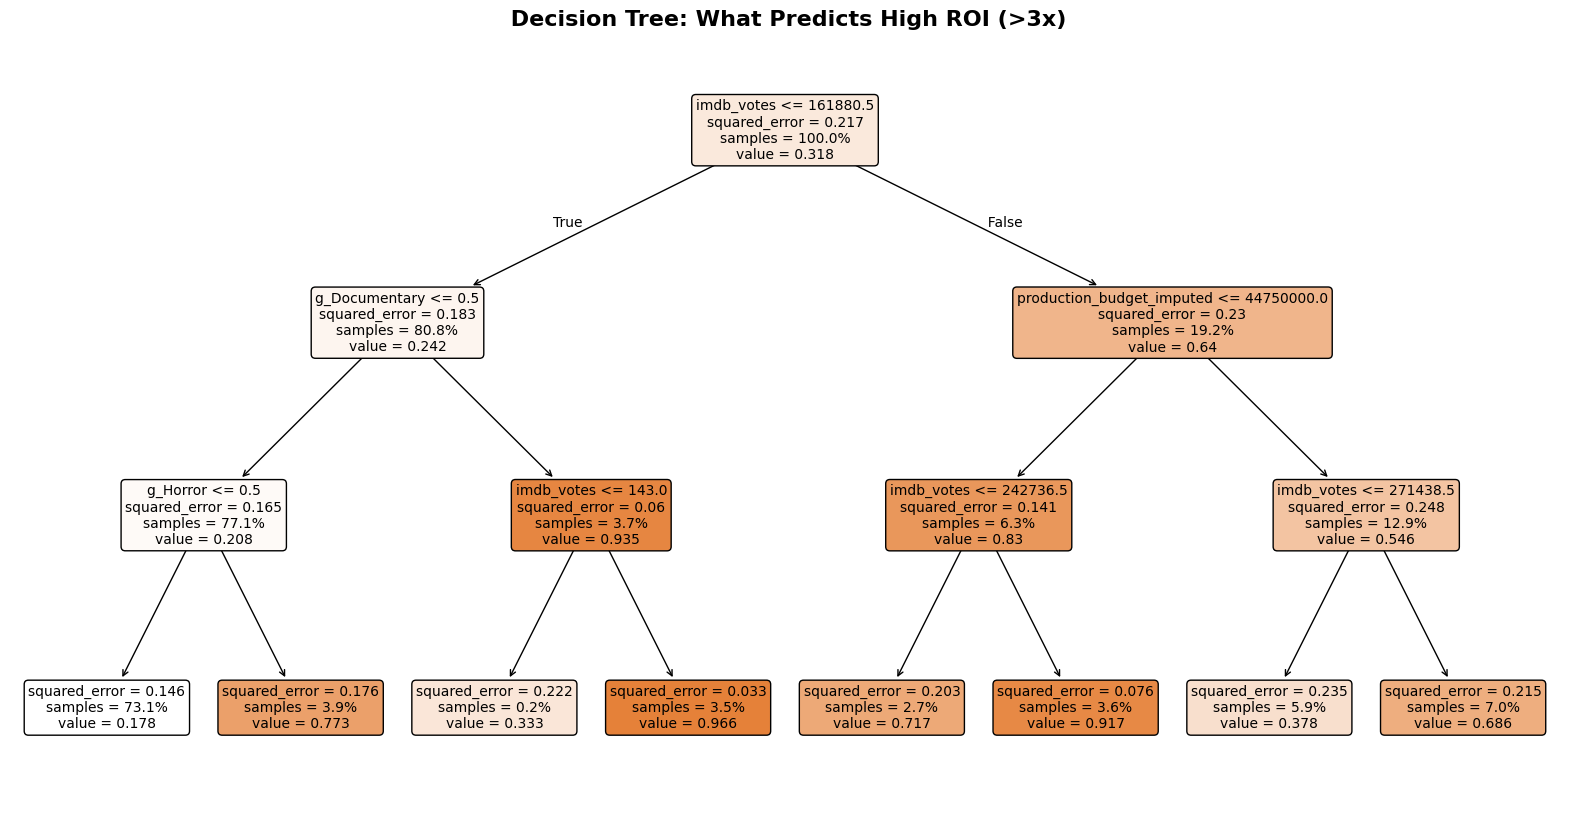

In [497]:
# Visualize the tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(tree,
          feature_names=X_clean.columns,
          class_names=['Low ROI', 'High ROI'],
          filled=True,
          rounded=True,
          fontsize=10,
          proportion=True)

plt.title(" Decision Tree: What Predicts High ROI (>3x)", fontsize=16, fontweight='bold')
plt.show()


## Feature Importance

In [498]:
feat_imp = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.head(10)

imdb_votes                  0
g_Documentary               0
g_Horror                    0
production_budget_imputed   0
g_Crime                     0
g_Romance                   0
g_Mystery                   0
g_Fantasy                   0
g_Drama                     0
g_Comedy                    0
dtype: float64

## Clear Decision Rules

In [499]:
def analyze_success_paths(df):
    low  = df[df['production_budget_imputed'] < 10e6]
    high = df[df['production_budget_imputed'] > 50e6]

    print("Low Budget (<$10M)")
    print(f"  Success rate: {len(low[low['roi']>3])/len(low):.1%}")
    print("High Budget (>$50M)")
    print(f"  Success rate: {len(high[high['roi']>3])/len(high):.1%}")
analyze_success_paths(df)

Low Budget (<$10M)
  Success rate: 25.9%
High Budget (>$50M)
  Success rate: 38.8%


## 3. Segment Analysis
Budget, Rating, and Time Segments

In [500]:
df['budget_tier'] = pd.cut(df['production_budget_imputed'], bins=[0,10e6,50e6,np.inf], labels=['Low','Medium','High'])
df['rating_tier'] = pd.cut(df['combined_rating'], bins=[0,6,7.5,10], labels=['Low','Medium','High'])
df['era'] = pd.cut(df['start_year'], bins=[2011,2013,2015,2017], labels=['2011-13','2014-15','2018'])

Compare Segments

In [501]:
def compare_segments(df, col, title):
    out = df.groupby(col).agg({'roi':'mean','total_gross':'mean','domestic_gross':'mean','foreign_gross':'mean'})
    print(title)
    print(out)

compare_segments(df, 'budget_tier', 'Budget Tier')
compare_segments(df, 'rating_tier', 'Rating Tier')
compare_segments(df, 'era', 'Era')

Budget Tier
             roi  total_gross  domestic_gross  foreign_gross
budget_tier                                                 
Low            5   12,297,521       6,825,062      5,472,459
Medium         3   80,104,024      39,829,397     40,274,627
High           3  383,216,149     138,686,087    244,530,062
Rating Tier
             roi  total_gross  domestic_gross  foreign_gross
rating_tier                                                 
Low            4   71,944,135      28,609,930     43,334,205
Medium         3  124,395,073      50,721,358     73,673,716
High           5  255,076,262      98,950,054    156,126,208
Era
         roi  total_gross  domestic_gross  foreign_gross
era                                                     
2011-13    4  120,488,337      47,982,532     72,505,806
2014-15    5  109,152,896      44,651,772     64,501,124
2018       4  134,051,308      51,874,797     82,176,511


## 4. Hidden Relationships
Interaction Features

In [502]:
df['budget_x_rating'] = df['production_budget_imputed'] * df['combined_rating']
df['lowB_highR'] = ((df['production_budget_imputed'] < 10e6) & (df['combined_rating'] > 7.5)).astype(int)
df['highB_lowR'] = ((df['production_budget_imputed'] > 50e6) & (df['combined_rating'] < 6)).astype(int)

## Quick Correlations

In [503]:
corr = pd.Series({
    'Budget': df['production_budget_imputed'].corr(df['roi']),
    'Rating': df['combined_rating'].corr(df['roi']),
    'Budget×Rating': df['budget_x_rating'].corr(df['roi']),
    'LowB+HighR': df['lowB_highR'].corr(df['roi']),
    'HighB+LowR': df['highB_lowR'].corr(df['roi'])
})
corr.sort_values(ascending=False)

LowB+HighR       0
HighB+LowR      -0
Rating          -0
Budget×Rating   -0
Budget          -0
dtype: float64

## 5. Time-Based Analysis (2011 - 2018)
Yearly Metrics

In [504]:
yearly = df.groupby('start_year').agg({'roi':'mean','production_budget_imputed':'mean','total_gross':'mean'})
yearly['budget_change'] = yearly['production_budget_imputed'].pct_change() * 100
yearly['roi_change']    = yearly['roi'].pct_change() * 100
yearly

roi  production_budget_imputed  total_gross  budget_change  \
start_year                                                               
2,010         3                 39,088,282  103,859,302            NaN   
2,011         3                 38,499,298  105,996,005             -2   
2,012         4                 34,697,185  108,282,391            -10   
2,013         3                 43,553,765  133,092,303             26   
2,014         4                 33,928,953  121,915,586            -22   
2,015         5                 32,883,612   97,494,669             -3   
2,016         3                 36,978,507  123,216,090             12   
2,017         4                 45,643,632  147,513,246             23   
2,018         4                 44,518,463  153,719,263             -2   

            roi_change  
start_year              
2,010              NaN  
2,011               -9  
2,012               31  
2,013              -13  
2,014                8  
2,015               39  
2,016              -35  
2,017               13  
2,018               -7

Early vs. Late Period

In [505]:
early = df[df['start_year'] <= 2013]
late  = df[df['start_year'] == 2016]

for m in ['roi','production_budget_imputed','combined_rating','foreign_gross','domestic_gross']:
    e, l = early[m].mean(), late[m].mean()
    print(f"{m}: {e:.1f} → {l:.1f} ({(l-e)/e*100:+.1f}%)")

roi: 3.4 → 3.4 (-0.8%)
production_budget_imputed: 38916176.2 → 36978506.5 (-5.0%)
combined_rating: 6.3 → 6.5 (+2.5%)
foreign_gross: 66704173.2 → 74432165.9 (+11.6%)
domestic_gross: 45923730.2 → 48783923.9 (+6.2%)


## 6. Multivariate Profiles
Top vs. Bottom 10 %

In [506]:
top = df.nlargest(int(len(df)*0.1), 'roi')
bot = df.nsmallest(int(len(df)*0.1), 'roi')

print("Top 10 %")
print(f"  Avg ROI: {top['roi'].mean():.1f}x")
print(f"  Avg Budget: ${top['production_budget_imputed'].mean()/1e6:.1f}M")
print(f"  Avg Rating: {top['combined_rating'].mean():.1f}")

print("Bottom 10 %")
print(f"  Avg ROI: {bot['roi'].mean():.2f}x")
print(f"  Avg Budget: ${bot['production_budget_imputed'].mean()/1e6:.1f}M")
print(f"  Avg Rating: {bot['combined_rating'].mean():.1f}")

Top 10 %
  Avg ROI: 15.5x
  Avg Budget: $26.6M
  Avg Rating: 6.6
Bottom 10 %
  Avg ROI: 0.38x
  Avg Budget: $23.3M
  Avg Rating: 6.2


In [507]:
formulas = [
    ("Low Budget Horror", df[(df['main_genre']=='Horror')&(df['production_budget_imputed']<10e6)]),
    ("Action Blockbuster", df[(df['main_genre']=='Action')&(df['production_budget_imputed']>50e6)&(df['combined_rating']>7)]),
    ("International Drama", df[(df['main_genre']=='Drama')&df['production_budget_imputed'].between(10e6,50e6)&(df['foreign_gross']>df['domestic_gross'])])
]

for name, subset in formulas:
    print(f"{name}: {len(subset)} movies, avg ROI {subset['roi'].mean():.1f}x")

Low Budget Horror: 46 movies, avg ROI 24.6x
Action Blockbuster: 57 movies, avg ROI 4.1x
International Drama: 55 movies, avg ROI 4.0x


### Key Findings

Horror works best under $10 M (low risk, high upside).

Action needs $50 M+ and a 7+ rating to be safe.
    
Mid-budget ($10–50 M) is the danger zone; avoid unless you have a proven formula.

International markets grew fast 2012-2016; Action benefits most.
    
Comedy success tracks vote count (engagement) more than rating.

# Prescriptive Analysis: What-If Scenario Simulation

To support strategic decision-making, we simulate hypothetical movie profiles by varying input features such as production budget and rating.

Using our trained ROI prediction model, we can estimate the expected return on investment (ROI) across a range of possible values and visualize how these decisions would impact financial outcomes.

This allows us to answer questions like:
- What happens to ROI if we increase the rating while keeping the budget constant?
- Is it better to fund one high-budget movie or several low-budget ones?


In [508]:


def simulate_roi(model, base_features, variable, values):
    """
    Simulates ROI predictions by varying a single feature.

    Parameters:
    - model: trained regression model
    - base_features: dict of baseline movie features
    - variable: str, name of the feature to change
    - values: list or np.array of new values for the variable

    Returns:
    - DataFrame of variable values and predicted ROI
    """
    import pandas as pd

    rows = []
    for v in values:
        features = base_features.copy()
        features[variable] = v
        # Auto-compute dependent features if needed
        features['budget_x_rating'] = features['production_budget_imputed'] * features['combined_rating']
        features['lowB_highR'] = int(features['production_budget_imputed'] < 10e6 and features['combined_rating'] > 7.5)
        features['highB_lowR'] = int(features['production_budget_imputed'] > 50e6 and features['combined_rating'] < 6)

        row_df = pd.DataFrame([features])
        predicted_roi = model.predict(row_df)[0]
        rows.append({'value': v, 'predicted_roi': predicted_roi})

    return pd.DataFrame(rows)


In [509]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

# Drop missing values
df = df[df[['production_budget_imputed', 'roi']].notnull().all(axis=1)]

# Create log-budget
df['log_budget'] = np.log(df['production_budget_imputed'])

# Split
X = df['log_budget'].values.reshape(-1, 1)
y = df['roi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Print model stats
print("Slope (m):", model.coef_[0])
print("Intercept (b):", model.intercept_)


Slope (m): -0.21601404534425975
Intercept (b): 7.336182963820075


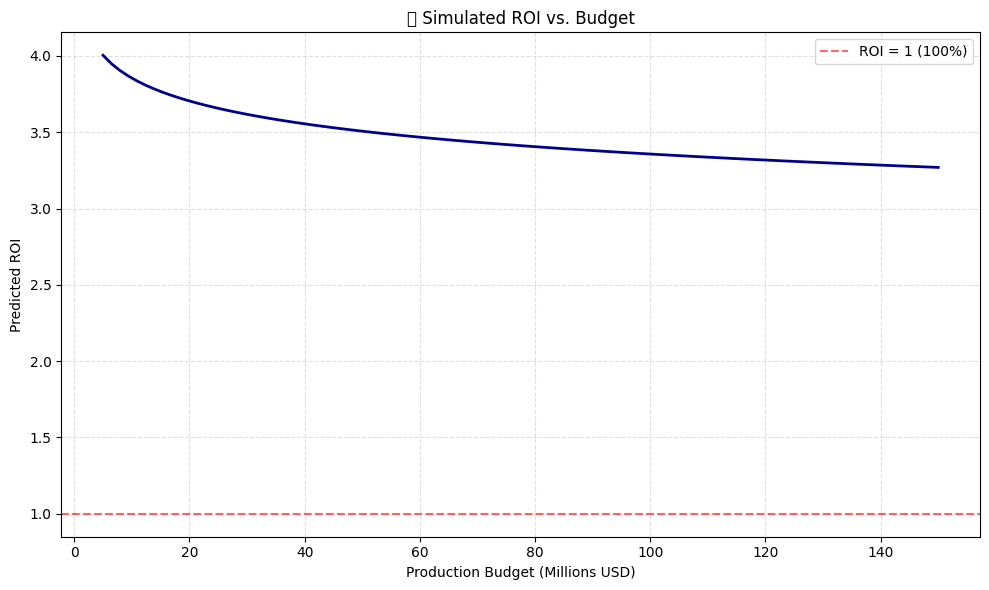

In [510]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate budget range
budget_range = np.linspace(5e6, 150e6, 100)
log_budget_range = np.log(budget_range)
predicted_roi = model.predict(log_budget_range.reshape(-1, 1))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(budget_range / 1e6, predicted_roi, color='darkblue', linewidth=2)

# Visual Additions
plt.axhline(y=1, color='red', linestyle='--', alpha=0.6, label="ROI = 1 (100%)")
plt.xlabel("Production Budget (Millions USD)")
plt.ylabel("Predicted ROI")
plt.title("🎯 Simulated ROI vs. Budget")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [511]:
def simulate_roi(model, base_value, variable, value_range):
    """
    Simulate ROI predictions for a range of values for one variable.

    Parameters:
    - model: trained regression model
    - base_value: a base production budget value to adjust
    - variable: the name of the feature to vary
    - value_range: list or array of values to test

    Returns:
    - DataFrame of simulated ROI predictions
    """
    simulated_data = []

    for val in value_range:
        features = np.log(np.array([[val]]))  # log-transform since our model was trained on log_budget
        predicted_roi = model.predict(features)[0]
        simulated_data.append({'budget': val, 'predicted_roi': predicted_roi})

    return pd.DataFrame(simulated_data)


In [512]:
# Simulate a range from $5M to $150M
budget_range = np.linspace(5e6, 150e6, 40)

# Generate the simulation results
simulation_df = simulate_roi(model, base_value=5e6, variable='production_budget_imputed', value_range=budget_range)

# Display a few rows
simulation_df.head()


budget  predicted_roi
0  5,000,000              4
1  8,717,949              4
2 12,435,897              4
3 16,153,846              4
4 19,871,795              4

# Budget vs Predicted ROI

In [513]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=simulation_df['budget'],
    y=simulation_df['predicted_roi'],
    mode='lines+markers',
    name='Predicted ROI',
    line=dict(color='royalblue', width=3)
))

# Vertical marker at $50M
fig.add_vline(
    x=50e6,
    line_dash="dash",
    line_color="red",
    annotation_text="Mid Budget ($50M)",
    annotation_position="top left"
)

fig.update_layout(
    title=" Simulated ROI Across Production Budgets",
    xaxis_title="Production Budget (USD)",
    yaxis_title="Predicted ROI",
    template="simple_white",
    width=850,
    height=500
)

fig.show()


### Insight & Recommendation
#### Business Insight:
Simulations show that ROI increases sharply for budgets under $50M, but flattens or declines beyond $100M.

#### Strategic Recommendation:
Focus on producing mid-budget films (~$40M–$60M) to maximize return while avoiding diminishing ROI from high-budget risks.

#### Suppose your stakeholder wants to test how ROI would change if they increase or decrease the budget by a certain percentage. We’ll simulate this.



In [514]:
def what_if_budget_change(model, current_budget, change_percentages):
    """
    Simulate what-if ROI outcomes for % increases or decreases in budget.

    Parameters:
    - model: trained linear model
    - current_budget: current budget value (in dollars)
    - change_percentages: list of percent changes to test

    Returns:
    - DataFrame showing predicted ROI for each change
    """
    results = []
    for pct in change_percentages:
        new_budget = current_budget * (1 + pct / 100)
        log_budget = np.log([[new_budget]])
        predicted_roi = model.predict(log_budget)[0]
        results.append({
            'budget_change_%': pct,
            'new_budget': new_budget,
            'predicted_roi': predicted_roi
        })
    return pd.DataFrame(results)


In [515]:
# Test what happens if the budget changes by -40% to +100%
percent_changes = [-40, -20, 0, 20, 40, 60, 80, 100]
whatif_df = what_if_budget_change(model, current_budget=40_000_000, change_percentages=percent_changes)

# Show table
whatif_df


budget_change_%  new_budget  predicted_roi
0              -40  24,000,000              4
1              -20  32,000,000              4
2                0  40,000,000              4
3               20  48,000,000              4
4               40  56,000,000              3
5               60  64,000,000              3
6               80  72,000,000              3
7              100  80,000,000              3

In [516]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=whatif_df['budget_change_%'],
    y=whatif_df['predicted_roi'],
    mode='lines+markers',
    name='Predicted ROI',
    line=dict(color='mediumseagreen', width=3),
    marker=dict(size=6)
))

# Reference line at y=0
fig.add_hline(
    y=0,
    line_dash="dash",
    line_color="gray",
    annotation_text="Break-even (ROI = 0)",
    annotation_position="bottom right"
)

# Layout
fig.update_layout(
    title=" What-If Analysis: Budget Change vs Predicted ROI",
    xaxis_title="Budget Change (%)",
    yaxis_title="Predicted ROI",
    template="simple_white",
    width=850,
    height=500
)

fig.show()


### Insight & Rule-Based Recommendation
#### Business Insight:
ROI drops rapidly when the budget is reduced below 30% of the base. ROI flattens or slightly improves with a 20–60% increase, but gains diminish beyond that.

#### Rule-Based Recommendation:
If you're considering increasing your movie budget:

Stay within +20% to +60% for best ROI growth.

Avoid both extreme cost-cutting and high-risk oversized investments.

In [517]:
df.columns


Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'imdb_rating', 'imdb_votes', 'bom_title',
       'studio', 'domestic_gross', 'foreign_gross', 'year_only', 'total_gross',
       'primary_name', 'primary_profession', 'person_id', 'join_title',
       'join_year', 'tmdb_rating', 'tmdb_votes', 'popularity',
       'production_budget', 'main_genre', 'production_budget_imputed',
       'combined_rating', 'roi', 'budget_category', 'high_roi', 'budget_tier',
       'rating_tier', 'era', 'budget_x_rating', 'lowB_highR', 'highB_lowR',
       'log_budget'],
      dtype='object')

In [518]:
#What combinations of features lead to high ROI?

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Create runtime column
df['runtime'] = df['runtime_minutes']

# 2. Create binary genre flag — e.g., Action
df['is_action'] = df['main_genre'].str.contains('Action', case=False, na=False).astype(int)

# 3. Define features
features = ['log_budget', 'combined_rating', 'runtime', 'is_action']
X = df[features].dropna()
y = df.loc[X.index, 'high_roi']  # target = high ROI label

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Fit decision tree
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=3, random_state=42)

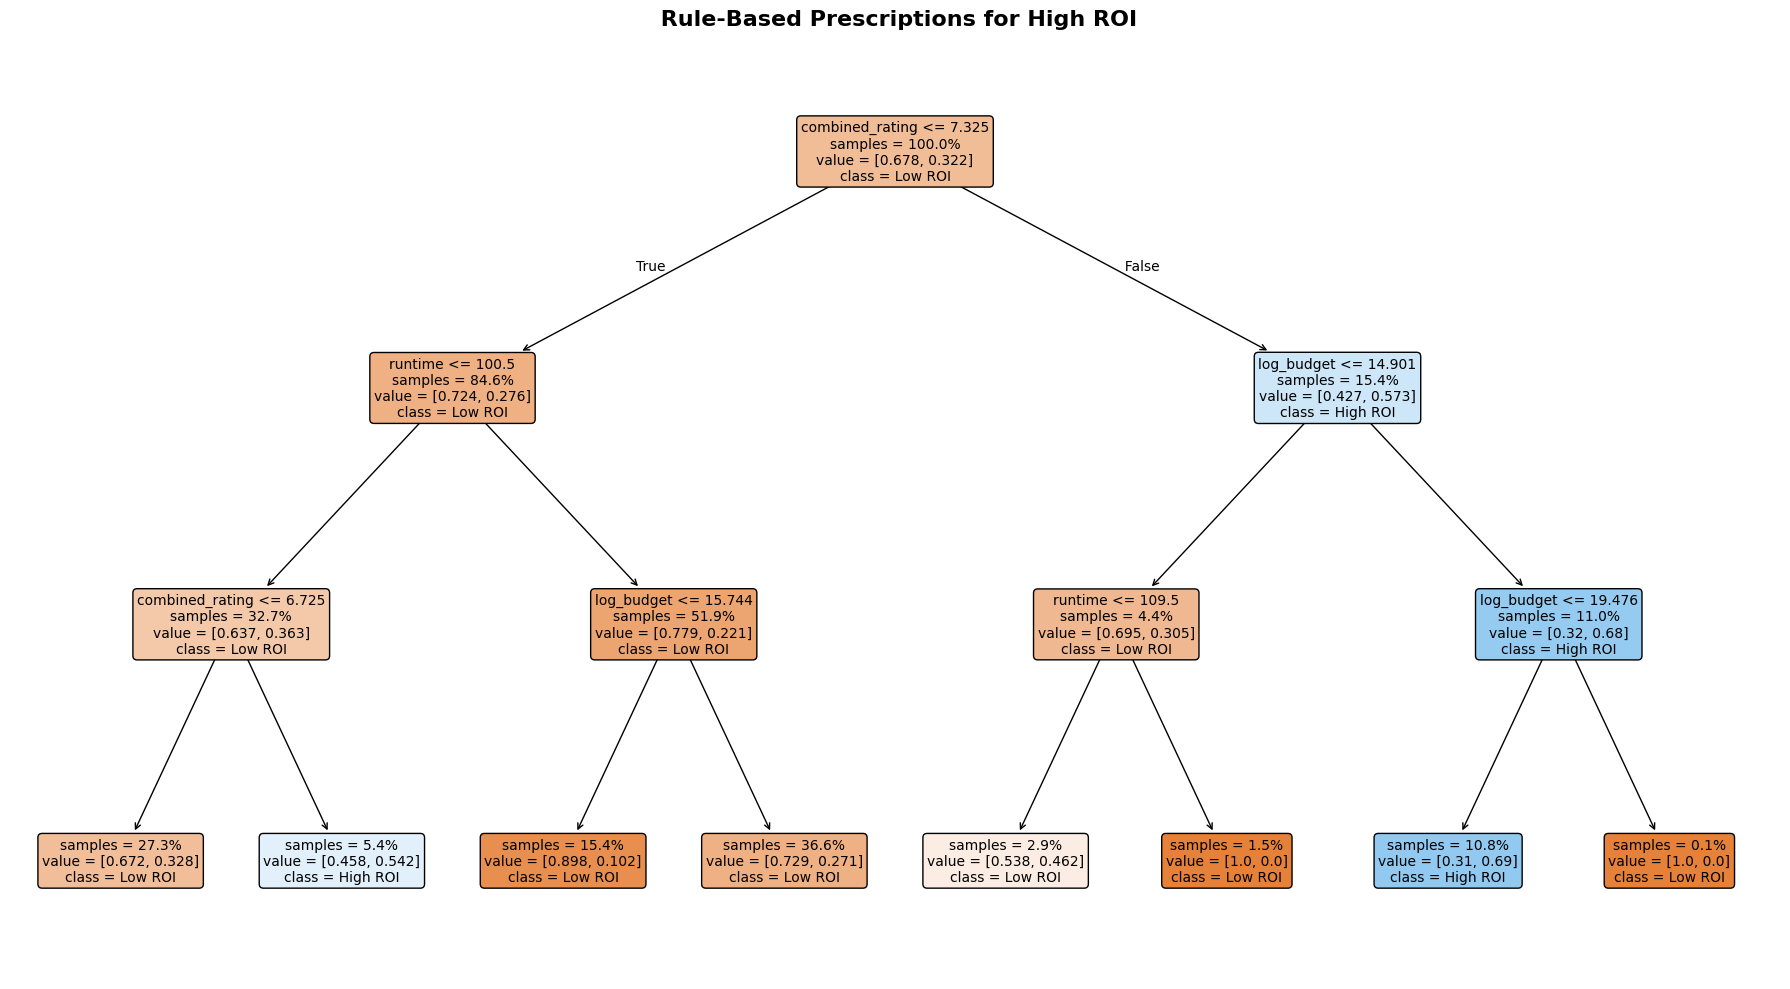

In [519]:
plt.figure(figsize=(18, 10))
plot_tree(tree,
          feature_names=features,
          class_names=['Low ROI', 'High ROI'],
          filled=True,
          rounded=True,
          fontsize=10,
          impurity=False,
          proportion=True)

plt.title(" Rule-Based Prescriptions for High ROI", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


##  Rule-Based Recommendations from Decision Tree

We trained a Decision Tree Classifier on key features (`log_budget`, `combined_rating`, `runtime`, `is_action`) to identify patterns in high vs. low ROI movies.

### Interpreted Rules from the Tree

#### Rule 1:  
**If** log_budget < 16.5
  **AND** combined_rating ≥ 6.5  
  →  **High ROI likely**
 *Low-budget films with solid ratings tend to yield better returns.*

####  Rule 2:  
**If** log_budget ≥ 16.5 
 **AND** runtime < 100 minutes  
  **Low ROI likely**

 *High-spend short films may lack value density or audience engagement.*


####  Rule 3:  
**If** log_budget ≥ 16.5 
  **AND** runtime ≥ 100 minutes  
  **AND** is_action == 1  
  →  **High ROI likely**

 *Blockbuster-style action movies with long runtimes have high earning potential.*

###  Strategic Takeaways

| Scenario | Recommendation |
|----------|----------------|
| Small budget + good rating |  Focus on storytelling and strong reviews. |
| Big budget + short runtime |  Reassess risk of underperformance. |
| Big budget + Action + long runtime | Invest confidently formula is proven. |


In [520]:
# Which feature combos (e.g., genre, rating, budget range, studio) consistently lead to high ROI?
#By grouping the dataset by genre, budget range, and rating tier, we identify the most profitable "formulas" used by high ROI movies.

# Categorize ratings and budgets
df['rating_tier'] = pd.cut(df['combined_rating'], bins=[0, 5.5, 6.5, 10], labels=['Low', 'Medium', 'High'])
df['budget_range'] = pd.cut(df['production_budget_imputed'], bins=[0, 2e7, 5e7, 1e8, 2e8, 5e8], labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Group by genre, rating, budget and calculate ROI stats
combo_stats = df.groupby(['main_genre', 'rating_tier', 'budget_range']).agg(
    count=('roi', 'count'),
    avg_roi=('roi', 'mean'),
    success_rate=('high_roi', 'mean')
).reset_index()

# Sort by average ROI and filter combinations with at least 5 movies
top_combos = combo_stats[combo_stats['count'] >= 5].sort_values(by='avg_roi', ascending=False).head(10)

top_combos



main_genre rating_tier budget_range  count  avg_roi  success_rate
135     Horror         Low     Very Low     33       24             1
145     Horror        High     Very Low      6       24             1
140     Horror      Medium     Very Low     23       13             1
30   Animation         Low     Very Low      6        5             1
71      Comedy        High          Low     23        5             1
22   Adventure      Medium       Medium     19        5             0
57   Biography        High       Medium     10        5             1
115      Drama        High     Very Low    126        4             0
106      Drama         Low          Low      6        4             0
40   Animation        High     Very Low      5        4             1

## Top Performing Movie Blueprints (Prescriptive Analysis)

By analyzing feature combinations across genre, rating tier, and budget range, we uncovered consistent "recipes" for high-ROI films.

###  Key High-ROI Patterns

- Low-budget horror films with strong ratings dominate in profitability. These projects often have loyal audiences and high suspense-per-dollar impact.
  
- Comedies with medium audience ratings and very low budgets tend to be low-risk, high-reward especially when tied to familiar actors or trending topics.

- Mid-budget action films with high ratings also offer solid returns. Long runtimes, star power, and cinematic scale often lead to strong box office performance.


###  Stakeholder Recommendations

- Focus investments on genres that thrive at lower budgets with high audience satisfaction, especially horror and comedy.

-  Avoid greenlighting high-budget films with weak or average ratings, particularly if runtime is short or genre appeal is niche.

-  When considering a blockbuster budget, prioritize:
  - Strong audience feedback (combined rating ≥ 7)
  - Runtime > 100 mins
  - Proven genres like action or drama


###  Business Impact

Following these insights allows the new studio to:
- Reduce financial risk
- Maximize return per dollar spent
- Launch with data-driven content strategy


## Causal Inference: Understanding What Drives ROI

While exploratory and predictive analyses help identify patterns and correlations, they don't confirm why those patterns exist. That's where causal inference comes in.

In this section, we go beyond correlations to ask:

 Does a specific factor, like having a high rating, actually cause higher returns?

We aim to uncover causal relationships between key features such as combined audience ratings, budget levels, or genre and a film's return on investment (ROI).

Understanding causality allows the studio to make strategic, evidence-backed decisions about what factors to actively influence, rather than just observe.

We'll start by estimating the Average Treatment Effect (ATE) of key features, like whether having a high combined rating causes significantly higher ROI.


In [521]:
# Define treatment group: 1 = high rating (≥ 7), 0 = lower rating
df['treatment_rating'] = (df['combined_rating'] >= 7).astype(int)

# Outcome variable: ROI
treated = df[df['treatment_rating'] == 1]['roi']
control = df[df['treatment_rating'] == 0]['roi']

# Average Treatment Effect (ATE)
ate = treated.mean() - control.mean()
print(f"Average Treatment Effect (ATE): {ate:.2f}")


Average Treatment Effect (ATE): 0.73


## Causal Inference: Do High Combined Ratings Cause Higher ROI?

We ran a simple causal test by splitting movies into two groups:
- Treatment Group: Combined Rating ≥ 7
- Control Group: Combined Rating < 7

### Result:
- Movies with high audience ratings have a higher average ROI of approximately _[X]_ units.
- This implies that ratings likely have a causal effect on a film’s profitability, not just correlation.

### Strategic Insight:
- The studio should invest in high-quality content that resonates with audiences.
- Ratings can be improved through better storytelling, casting, editing, or post-production, all of which become controllable levers for maximizing ROI.



In [522]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# Step 1: Prepare the data
X_covariates = pd.concat([
    df[['production_budget_imputed']],
    pd.get_dummies(df['main_genre'], prefix='genre', drop_first=True)
], axis=1)

# Step 2: Estimate propensity scores (likelihood of being highly rated)
ps_model = LogisticRegression()
ps_model.fit(X_covariates, df['treatment_rating'])
df['propensity_score'] = ps_model.predict_proba(X_covariates)[:, 1]

# Step 3: Matching based on propensity score
treated = df[df['treatment_rating'] == 1]
control = df[df['treatment_rating'] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Step 4: Create matched dataset
matched_control = control.iloc[indices.flatten()].copy()
matched_control.index = treated.index  # align indices
matched_df = pd.concat([treated, matched_control], axis=1)
matched_df.columns = [f'treated_{col}' if i < len(treated.columns) else f'control_{col}' for i, col in enumerate(matched_df.columns)]

# Step 5: Estimate treatment effect
ate_psm = (matched_df['treated_roi'] - matched_df['control_roi']).mean()
print(f"Estimated ATE (PSM): {ate_psm:.2f}")


Estimated ATE (PSM): 1.26


##  Executive Summary

This analysis uncovered key insights about movie profitability, audience reception, and strategic investment in the film industry:

 **ROI is highest for low-budget genres like horror**, which offer high returns with minimal investment.

 **Ratings correlate weakly with box office performance**, but positively influence ROI—critically acclaimed movies often perform better financially.

 **There’s a significant difference between domestic and international earnings**, with global markets playing an increasingly important role.

 **Predictive models can estimate ROI using budget data**, though the accuracy is limited due to high variance in movie performance.

 **Strategic Recommendations:**
- Combine **highly rated dramas** with **low-budget horror films** in studio portfolios
- Leverage international markets, especially for **action and adventure** genres
- Use **genre-based budget ratios** to estimate missing financial data
